#  Projet Data Science Covid
Sous la supervision de :
- Maxime Ferreira Da Costa

Etudiants :
- Emma Greverie
- Lucas Tramonte
- Romain Dalcant
- Jia Yi Ang

## Table des matières
> __1. Traitement de la base de données__<br>
> __2. Modèle SIR__<br>
> __3. Processus autorégressif avec des coefficients stationnaires__<br>
> __4. Processus autorégressif avec des coefficients non stationnaires__<br>

# Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
import itertools
import altair as alt
import time
from scipy import integrate
from scipy.optimize import minimize
from scipy.integrate import odeint
from concurrent.futures import ProcessPoolExecutor


## 1. Informations sur la base de données

In [ ]:
df=pd.read_csv('Assets\Dataset\covid-hospit.csv', sep= ';')
df = df[['dep','jour','hosp']]
df = df.rename({'hosp': 'nombre_de_cas'}, axis = 1)
df = df.loc[~df['dep'].isin(['2A', '2B'])]
df['dep'] = df['dep'].astype(int)
df['jour'] = pd.to_datetime(df['jour'])

# Liste des codes de départements souhaités
departements_souhaites = [21, 58, 71, 89, 18, 28, 36, 37, 41, 45, 8, 10, 51, 52, 27, 76, 75, 77, 78, 91, 92, 93, 94, 95, 2, 60, 80]

# Dictionnaire pour stocker les jeux de données séparés par département
datasets_par_departement = {}

# Itérer sur les codes de département
for dep in departements_souhaites:
  # Filtrer le DataFrame pour le département actuel
  departement_df = df[df['dep'] == dep]
  # Stocker le DataFrame dans le dictionnaire, en utilisant le code du département comme clé
  datasets_par_departement[dep] = departement_df

for dep, dataframe in datasets_par_departement.items():
    print(f"DataFrame pour le Département {dep} :")
    dataframe.reset_index(drop=True, inplace=True)
    dataframe = dataframe.groupby('jour')['nombre_de_cas'].sum()
    print("Premières lignes :")
    print(dataframe.head())
    print("\n Résumé du DataFrame :")
    print(dataframe.info())
    print("\n" + "="*40 + "\n")

DataFrame pour le Département 21 :
Premières lignes :
jour
2020-03-18    120
2020-03-19    106
2020-03-20    164
2020-03-21    158
2020-03-22    201
Name: nombre_de_cas, dtype: int64

 Résumé du DataFrame :
<class 'pandas.core.series.Series'>
DatetimeIndex: 1109 entries, 2020-03-18 to 2023-03-31
Series name: nombre_de_cas
Non-Null Count  Dtype
--------------  -----
1109 non-null   int64
dtypes: int64(1)
memory usage: 17.3 KB
None


DataFrame pour le Département 58 :
Premières lignes :
jour
2020-03-18    0
2020-03-19    0
2020-03-20    2
2020-03-21    2
2020-03-22    2
Name: nombre_de_cas, dtype: int64

 Résumé du DataFrame :
<class 'pandas.core.series.Series'>
DatetimeIndex: 1109 entries, 2020-03-18 to 2023-03-31
Series name: nombre_de_cas
Non-Null Count  Dtype
--------------  -----
1109 non-null   int64
dtypes: int64(1)
memory usage: 17.3 KB
None


DataFrame pour le Département 71 :
Premières lignes :
jour
2020-03-18     70
2020-03-19     96
2020-03-20    106
2020-03-21    100
2020-03

Traitement des données

In [ ]:
df

dep       jour  nombre_de_cas
0         1 2020-03-18              2
1         1 2020-03-18              1
2         1 2020-03-18              1
3         2 2020-03-18             41
4         2 2020-03-18             19
...     ...        ...            ...
338240  976 2023-03-31              0
338241  976 2023-03-31              0
338242  976 2023-03-31              0
338243  978 2023-03-31              0
338244  978 2023-03-31              0

[331591 rows x 3 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331591 entries, 0 to 338244
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   dep            331591 non-null  int64         
 1   jour           331591 non-null  datetime64[ns]
 2   nombre_de_cas  331591 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 10.1 MB


Frequence de nombre de cas

<Axes: >

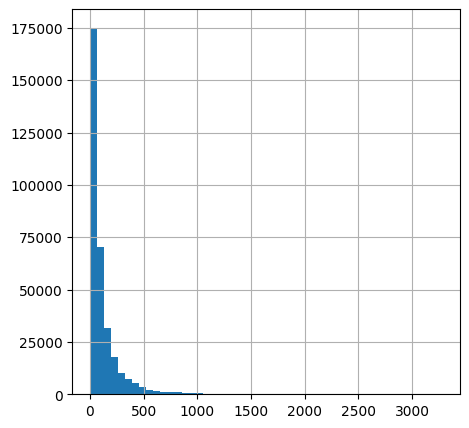

In [ ]:
df['nombre_de_cas'].hist(bins=50, figsize=(5, 5))

Fréquence de nombre de cas pour chaque département

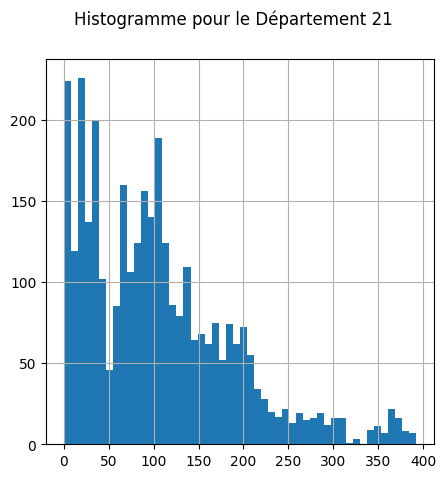

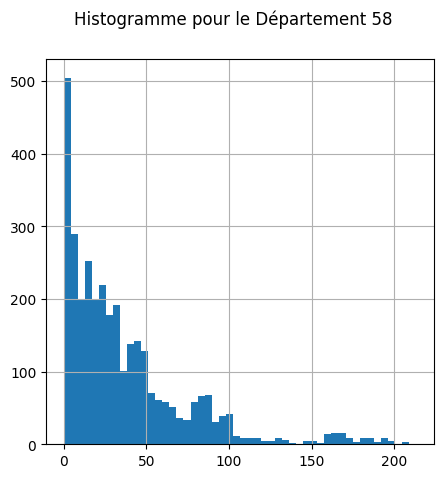

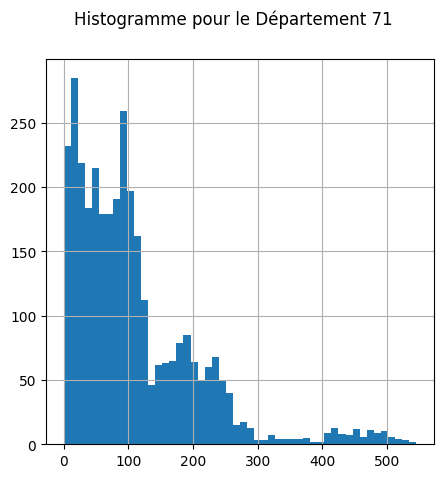

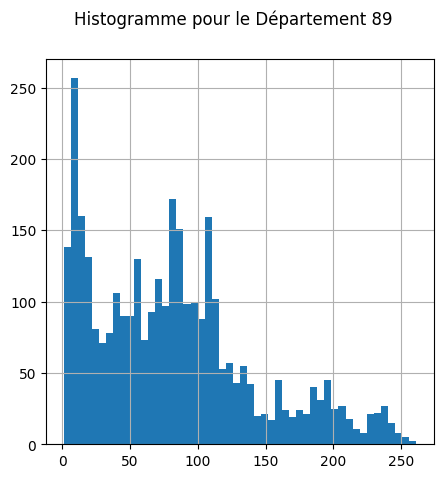

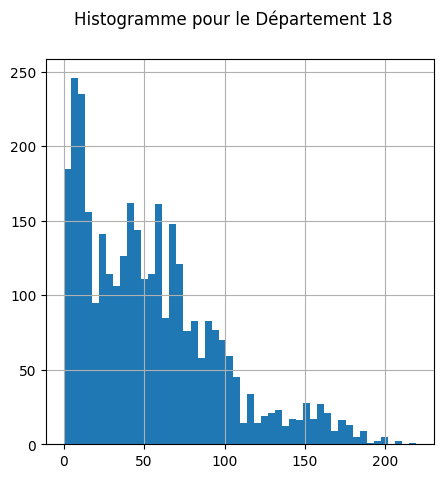

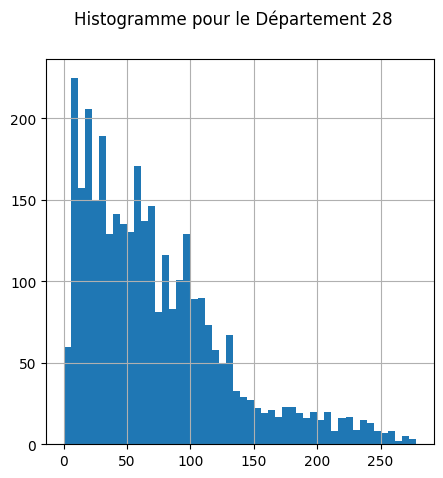

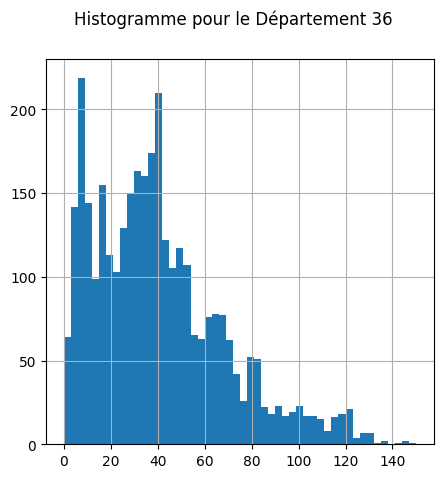

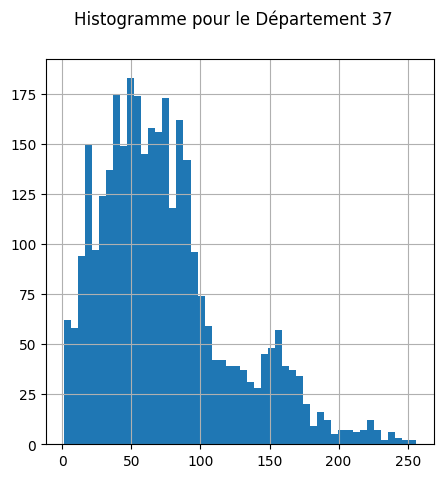

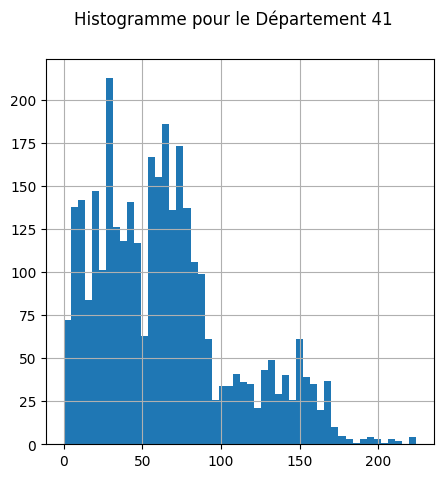

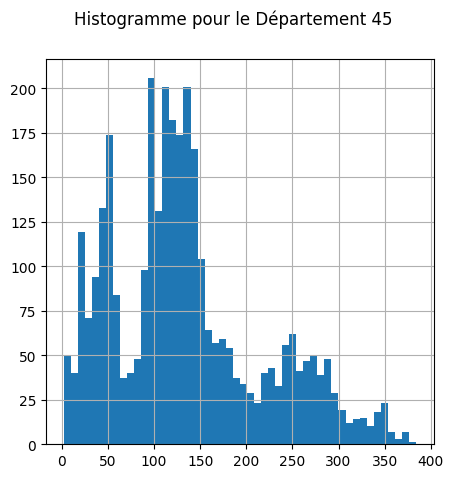

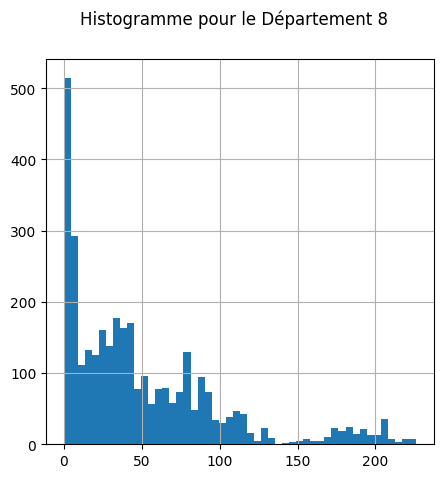

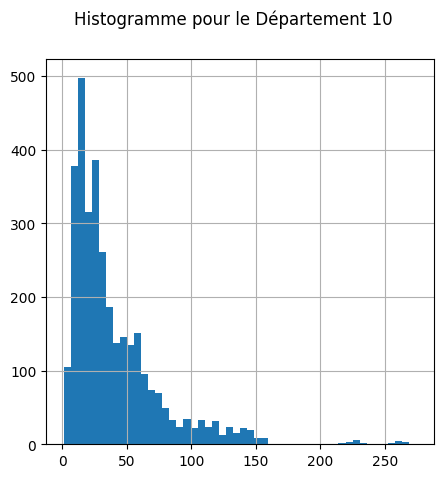

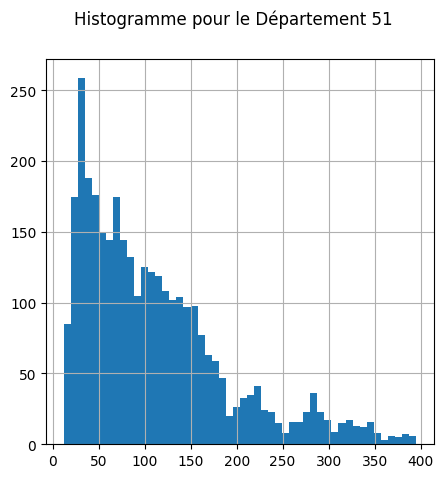

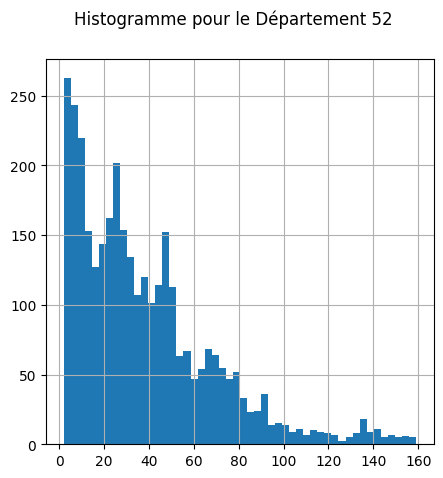

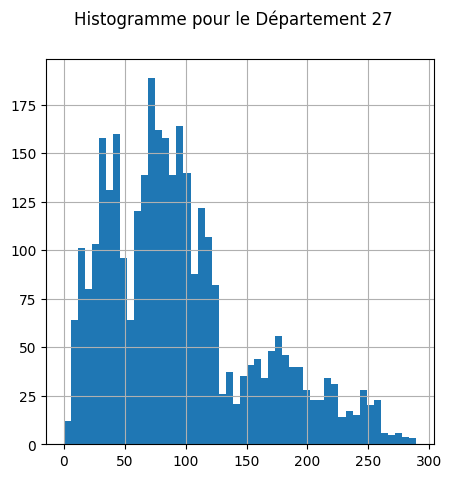

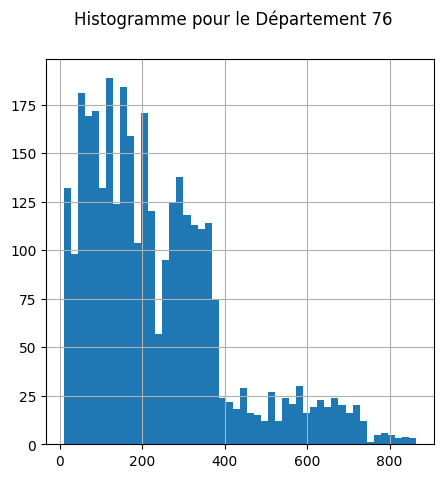

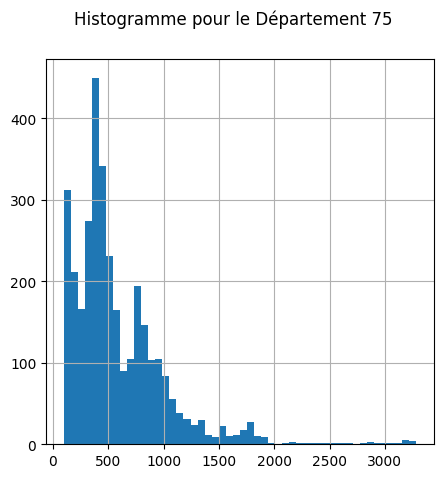

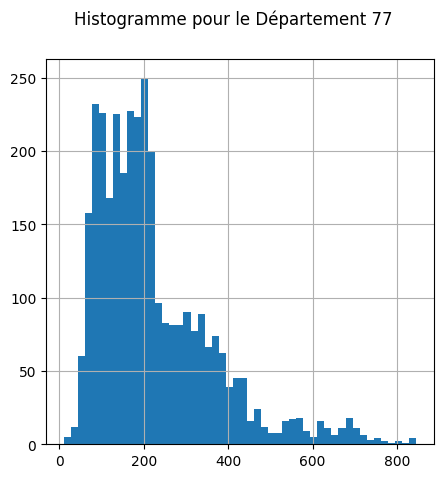

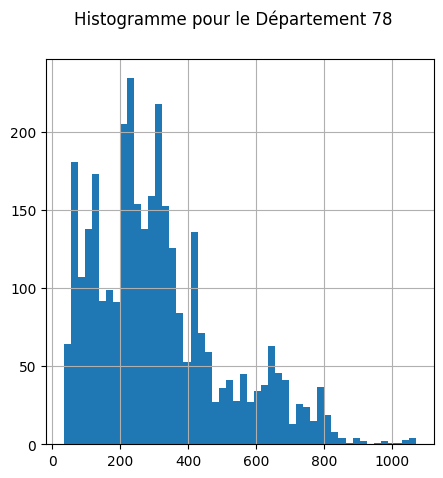

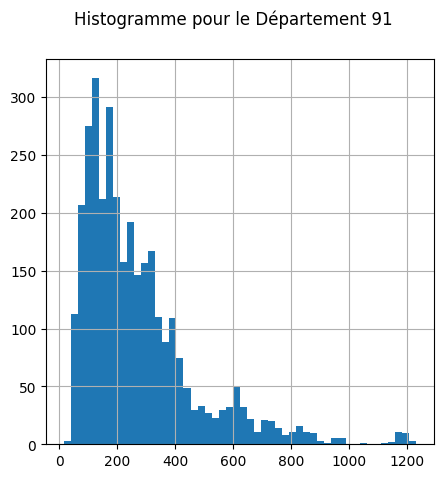

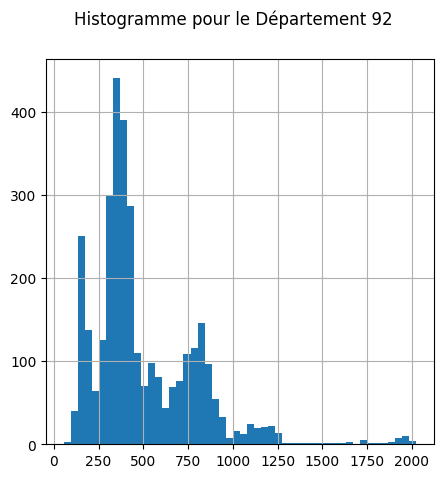

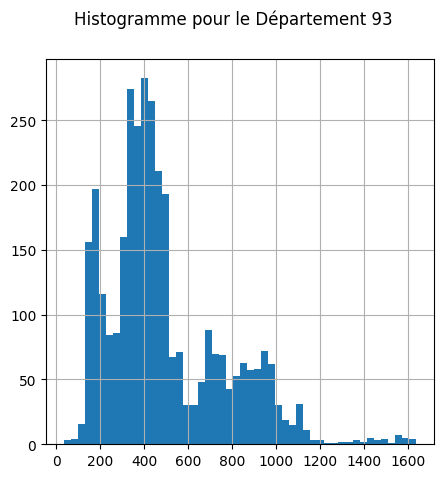

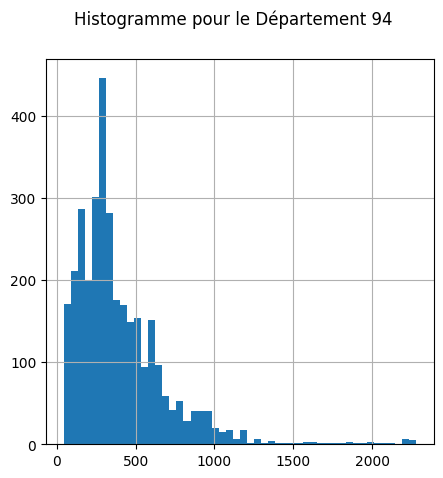

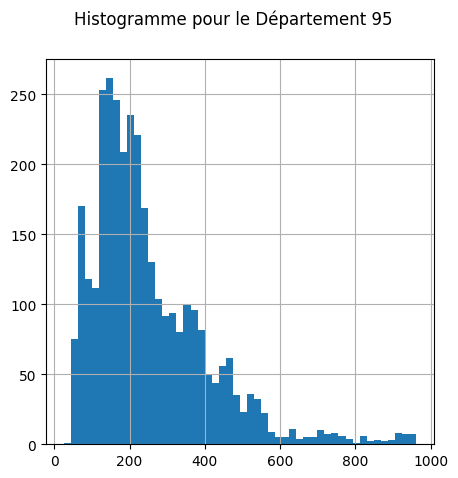

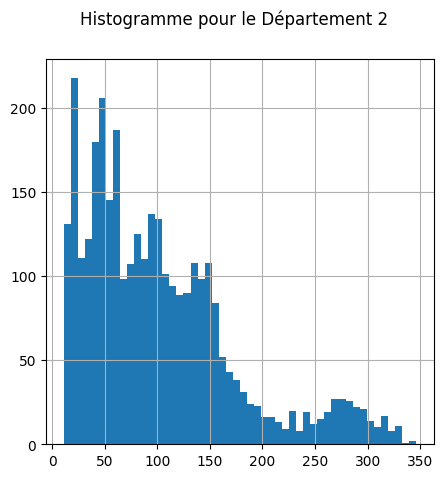

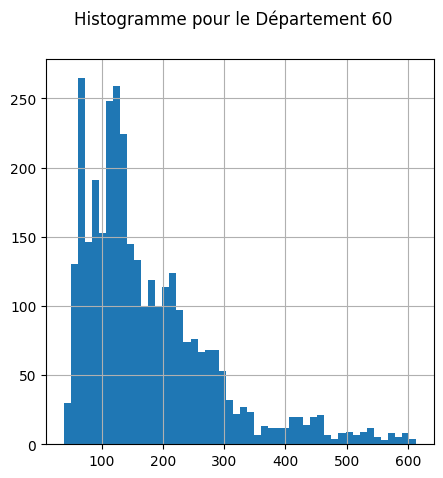

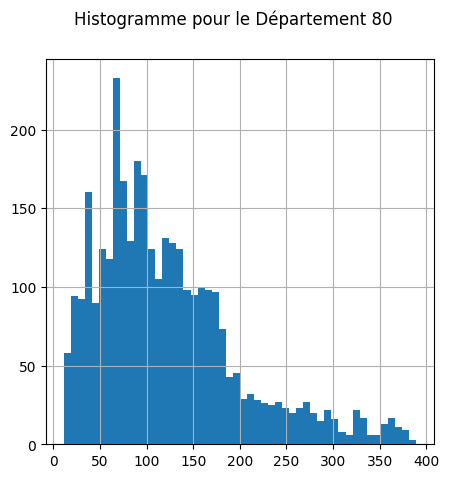

In [ ]:
for dep, dataframe in datasets_par_departement.items():
    dataframe['nombre_de_cas'].hist(bins=50, figsize=(5, 5))
    plt.suptitle(f'Histogramme pour le Département {dep}')
    plt.show()

df_jour = Dataframe qui a le nombre de cas par jour. Donc il faut faire attention parce que cette dataframe mélange les cas entre les départements, et n'est pas possible de faire une analyse locale, juste globale

In [ ]:
df_jour = pd.DataFrame(columns=['jour', 'nombre_de_cas'])
grouped_df = df.groupby('jour')['nombre_de_cas'].sum().reset_index()
df_jour['jour'] = grouped_df['jour']
df_jour['nombre_de_cas'] = grouped_df['nombre_de_cas']
df_jour

jour  nombre_de_cas
0    2020-03-18           5905
1    2020-03-19           7959
2    2020-03-20          10140
3    2020-03-21          11463
4    2020-03-22          13547
...         ...            ...
1104 2023-03-27          25775
1105 2023-03-28          25911
1106 2023-03-29          25931
1107 2023-03-30          25936
1108 2023-03-31          25859

[1109 rows x 2 columns]

Lissage de la courbe avec la méthode des moyennes mobiles.

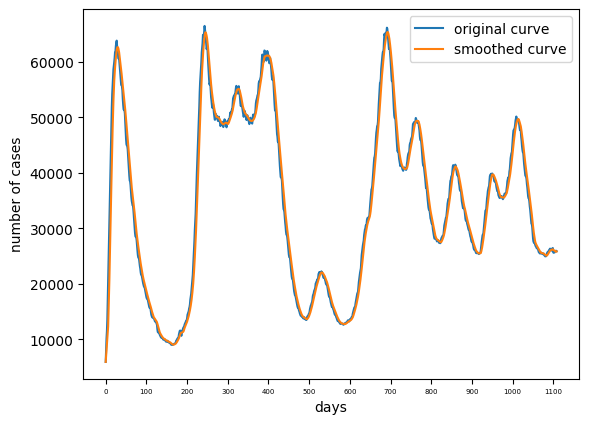

In [ ]:
coef_lis=0.1
df_jour['lissage'] = df_jour['nombre_de_cas'].rolling(window=7, min_periods=1).mean()

#Tracé de la courbe.
plt.plot(df_jour.index, df_jour['nombre_de_cas'], label='original curve')
plt.plot(df_jour.index, df_jour['lissage'],label ='smoothed curve')

plt.xlabel('days')
plt.ylabel('number of cases')

#On utilise ces 2 commandes parce que les valeurs étaient invisible sur l'axe x
tick_positions = np.arange(0, len(df_jour.index), 100)
plt.xticks(tick_positions,fontsize=5)

plt.legend(loc='best')
plt.show()

**Pour chaque département**

Visualisation pour le Département 21:


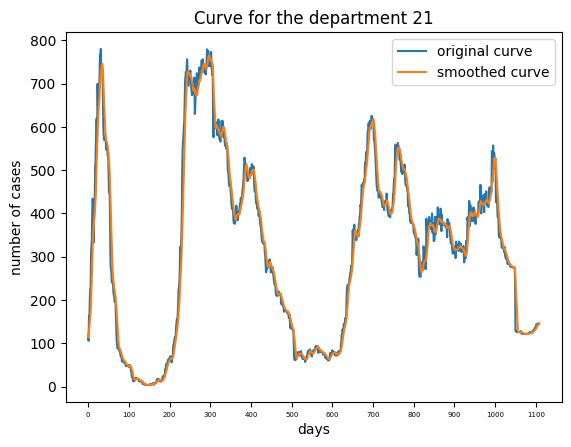

Visualisation pour le Département 58:


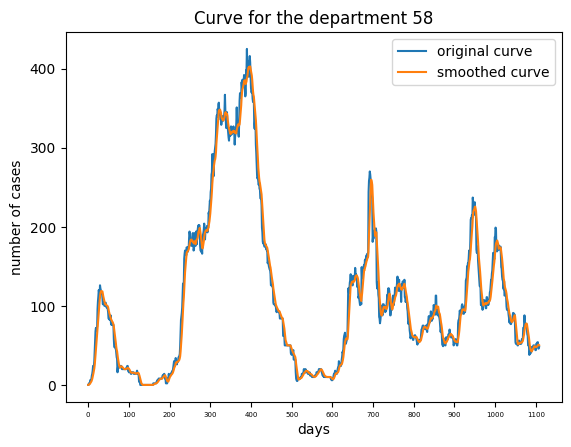

Visualisation pour le Département 71:


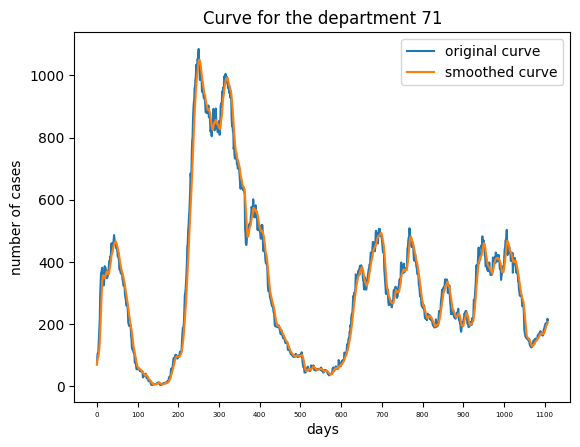

Visualisation pour le Département 89:


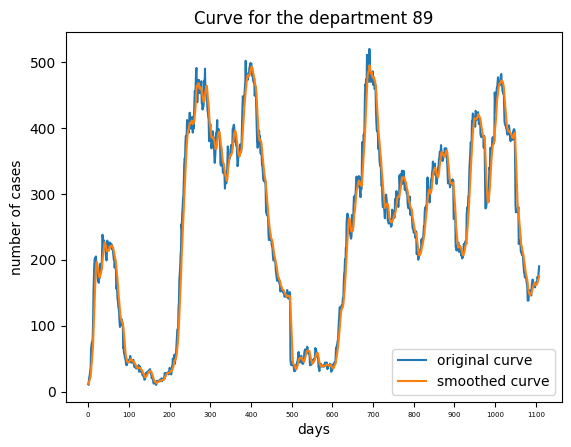

Visualisation pour le Département 18:


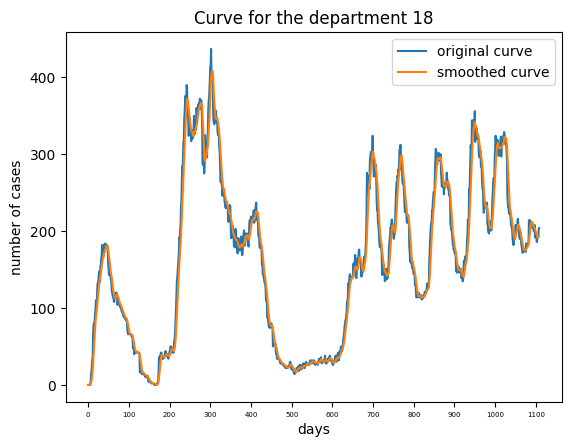

Visualisation pour le Département 28:


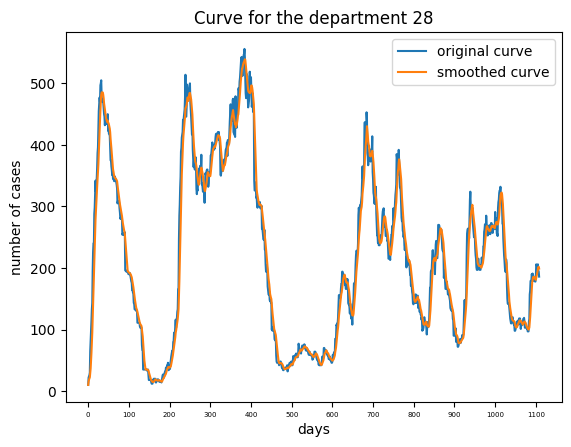

Visualisation pour le Département 36:


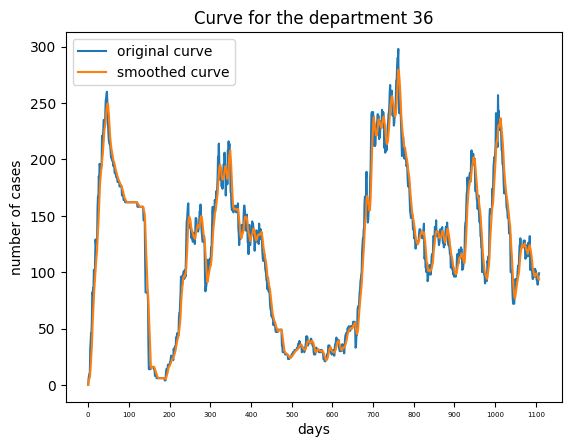

Visualisation pour le Département 37:


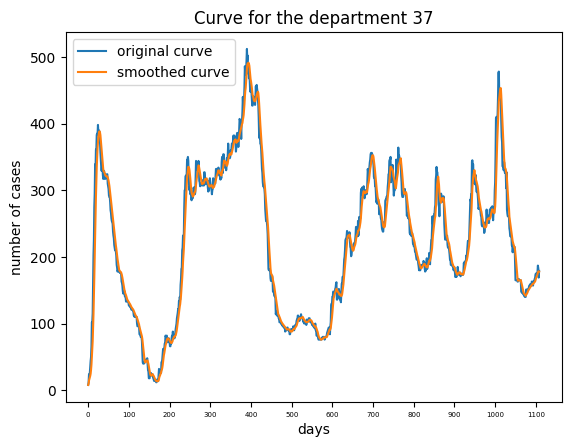

Visualisation pour le Département 41:


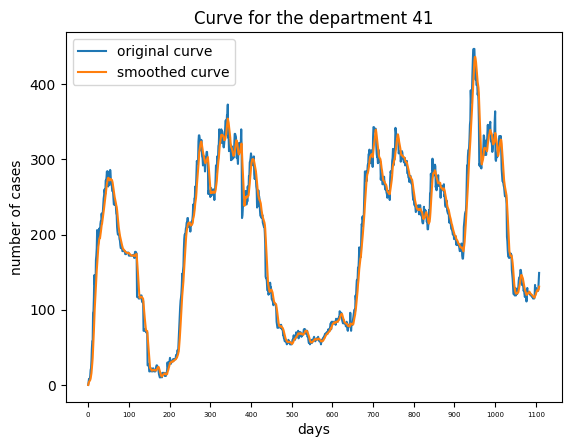

Visualisation pour le Département 45:


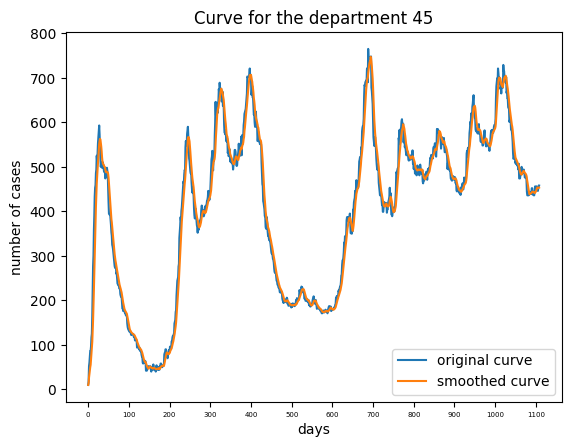

Visualisation pour le Département 8:


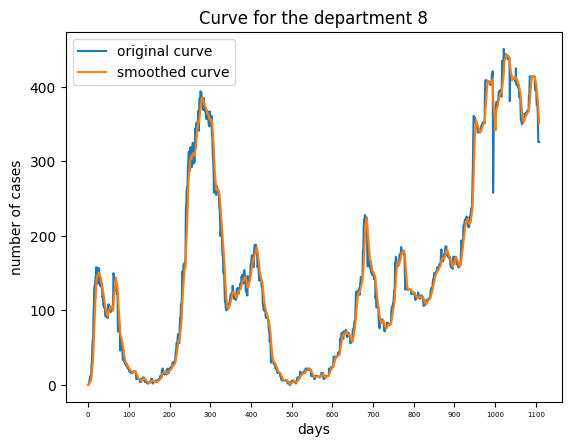

Visualisation pour le Département 10:


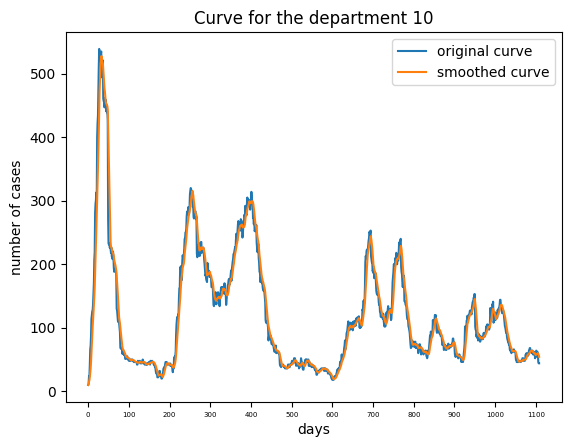

Visualisation pour le Département 51:


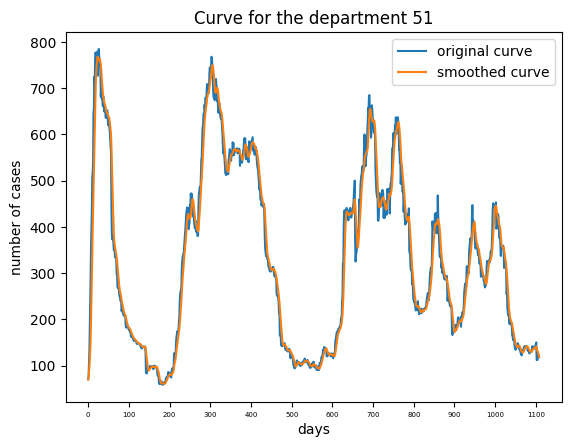

Visualisation pour le Département 52:


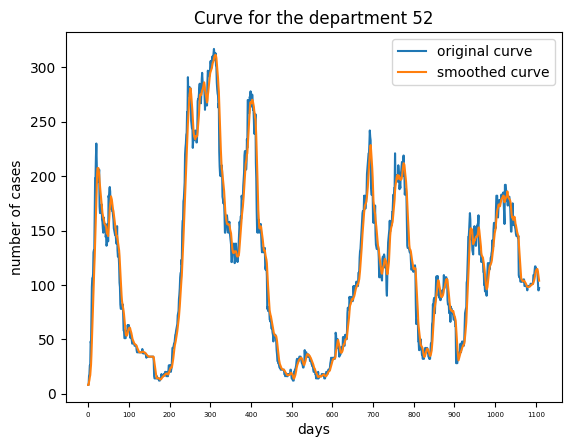

Visualisation pour le Département 27:


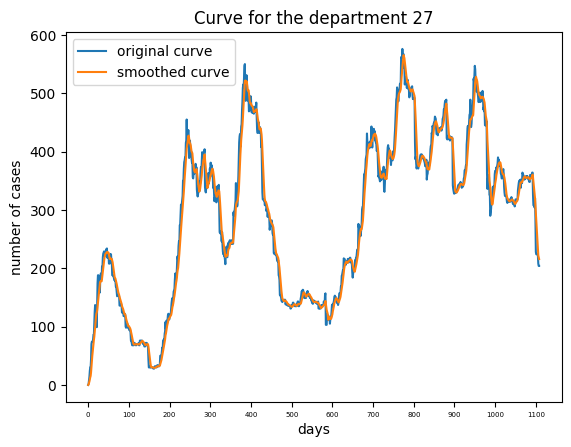

Visualisation pour le Département 76:


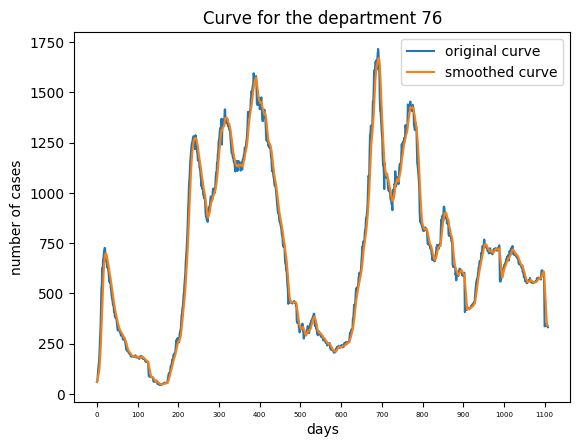

Visualisation pour le Département 75:


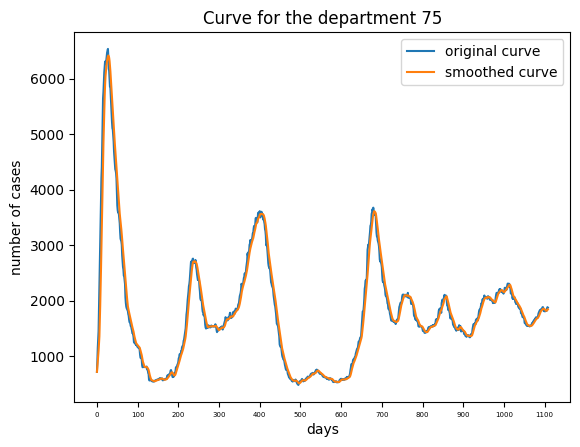

Visualisation pour le Département 77:


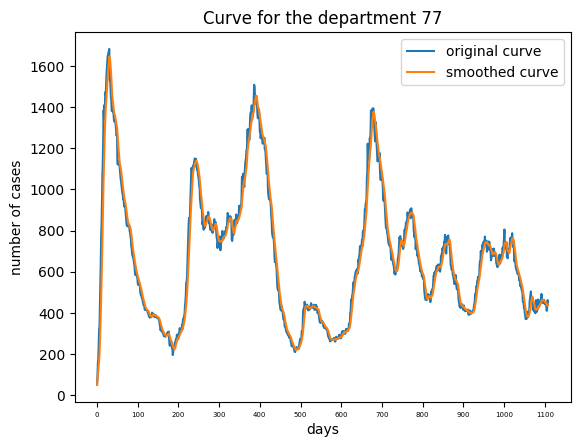

Visualisation pour le Département 78:


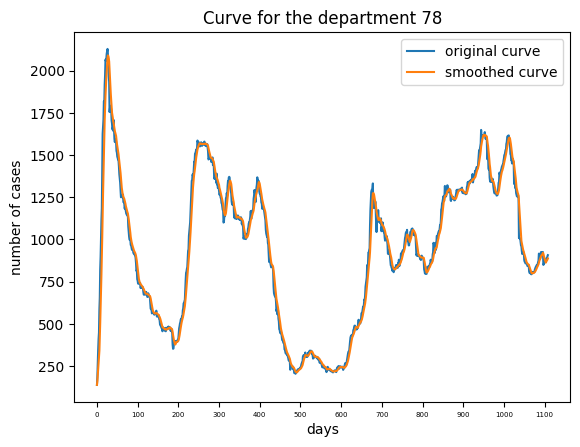

Visualisation pour le Département 91:


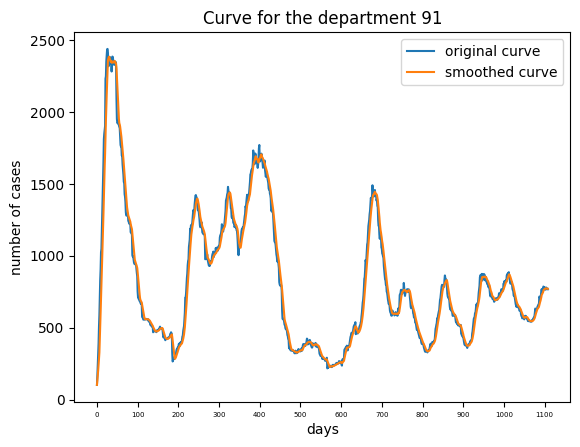

Visualisation pour le Département 92:


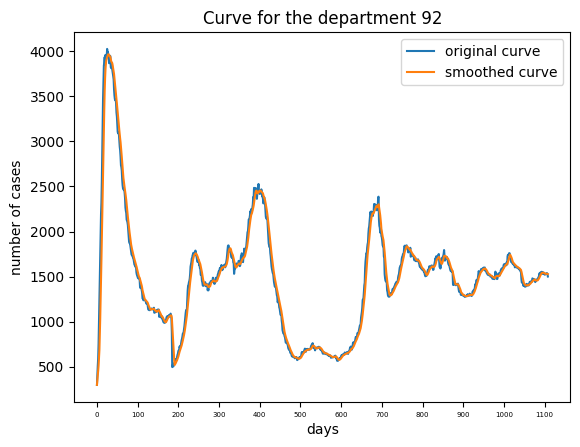

Visualisation pour le Département 93:


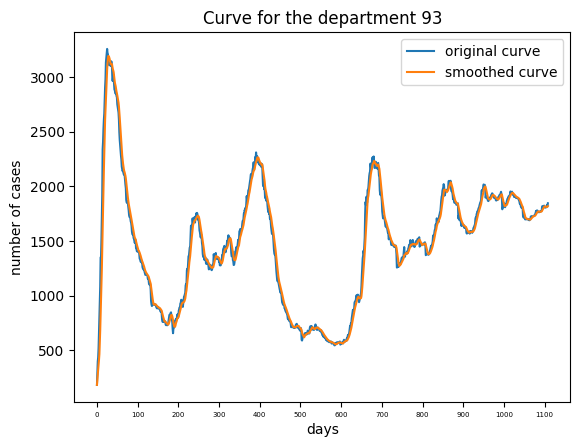

Visualisation pour le Département 94:


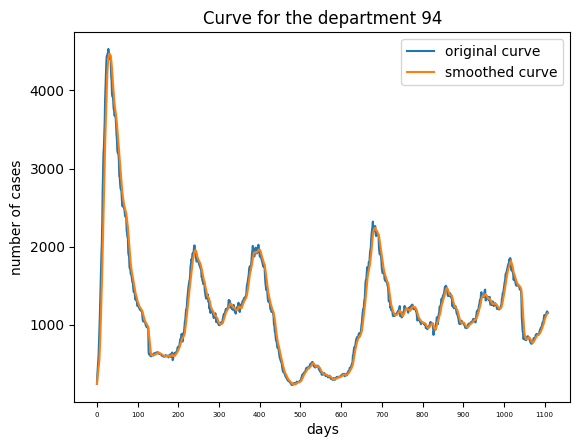

Visualisation pour le Département 95:


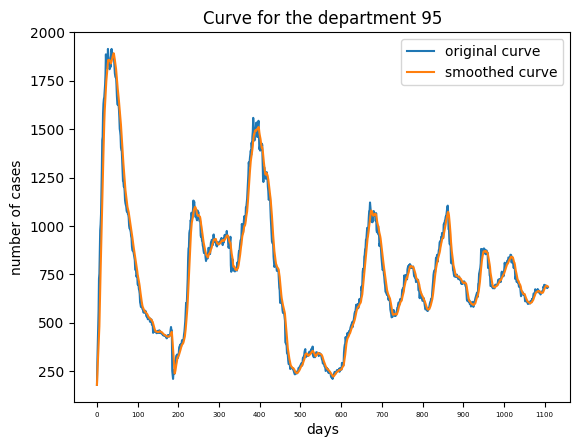

Visualisation pour le Département 2:


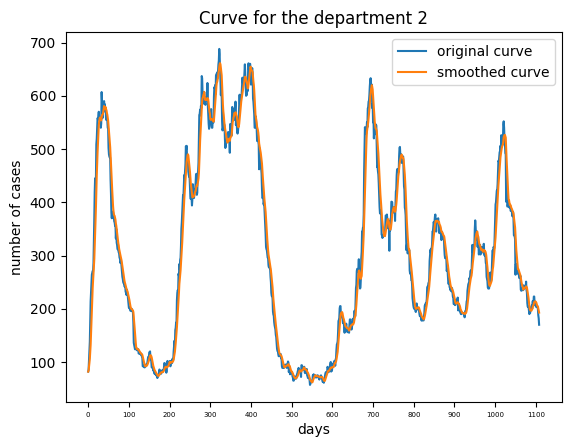

Visualisation pour le Département 60:


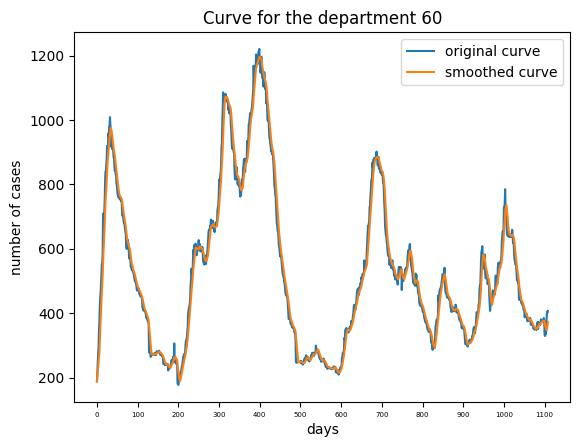

Visualisation pour le Département 80:


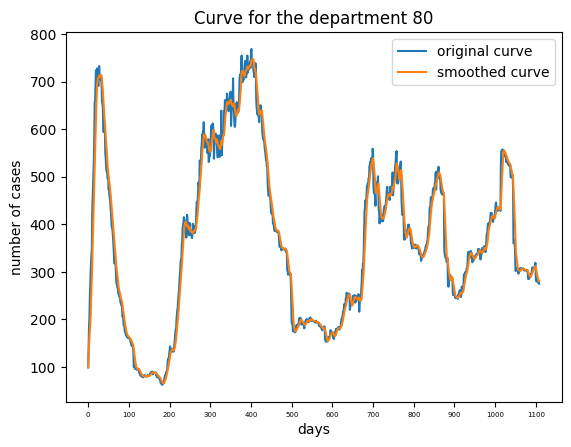

In [ ]:
coef_liss = 0.1

# Itérer sur les DataFrames et appliquer le lissage
for dep, dataframe in datasets_par_departement.items():
    print(f"Visualisation pour le Département {dep}:")

    dataframe = dataframe.groupby('jour')['nombre_de_cas'].sum().reset_index()
    dataframe = dataframe['nombre_de_cas'].to_frame()

    dataframe.loc[:, 'lissage'] = dataframe['nombre_de_cas'].rolling(window=7, min_periods=1).mean()

    plt.plot(dataframe.index, dataframe['nombre_de_cas'], label='original curve')
    plt.plot(dataframe.index, dataframe['lissage'], label='smoothed curve')

    plt.xlabel('days')
    plt.ylabel('number of cases')

    tick_positions = np.arange(0, len(dataframe.index), 100)
    plt.xticks(tick_positions, fontsize=5)

    plt.legend(loc='best')
    plt.title(f'Curve for the department {dep}')
    plt.show()

## 2. Modèle SIR

Pour modéliser notre système d'équation différentielles ordinaires, nous devons définir notre problème dans une fonction `def` comprenant

- `N`, un vecteur comprenant le nombre de personnes susceptibles (`S`), infectées (`I`) et rétablies (`R`).
- `t`, la variable par rapport à laquelle dériver
- Les paramètres `α` le taux de containation et `β` le taux de guérison
- les équation différentielles définies précédemment.

**Pour tous les départements**

In [ ]:
def dN_dt(N, t, α, β):
    S = N[0]
    I = N[1]
    R = N[2]
    dS_dt = -α * S * I
    dI_dt = α * S * I - β * I
    dR_dt = β * I
    return np.array([dS_dt, dI_dt, dR_dt])

#Établissons certains paramètres inspirés du COVID-19 en Ile-de-France.
nb_jours, n = 200,1000
time = np.linspace(0, nb_jours, n) # temps, jours
α = 0.01065 # taux d'infection en 1/(millions_personnes . jour)
β = 0.31 # taux de guérison, 1/jour
N_i = [36.47, 0.0162999, 0] # % population initiale en millions de personnes

#Ces paramètres nous permettent d'emblée de calculer le $\mathscr{R}_0$ au début de l'épidémie.

R_0 = N_i[0] * α / β
print("R_0:",'\n', R_0)

#La fonction ode agglomère les paramètres et la fonction pour solutionner le système.

solution = integrate.odeint(dN_dt, N_i, time, args = (α, β))

#Transformons ces résultats en un tableau prêt pour le graphique.

solution_df = pd.DataFrame(solution, columns = ["S", "I", "R"], index = time).reset_index()
solution_df = pd.melt(solution_df, id_vars="index")

alt.Chart(solution_df).mark_line().encode(
    x = "index",
    y = "value",
    color = "variable"
)

R_0: 
 1.2529209677419353


alt.Chart(...)

Ajoutons les données réels à la courbe des infections $I$.

In [ ]:
# Définir les valeurs de Z(t)
z = np.array(df_jour['nombre_de_cas'].tolist())
z = z*(500/(sum(z)))
retard =180
index_r = solution_df["index"].tolist()[:n]
value_r = []
for i in range(retard):
    value_r.append(None)
for i in range(retard,n):
    value_r.append(z[int(index_r[i-retard])])

data_r = pd.DataFrame(
    {
        "index": index_r,
        "variable": ["Cas Réels"]*n,
        "value": value_r,
    }
)

solution_df_r = solution_df[1000:2000].append(data_r)

#Comparaison de la courbe de  I  du modèle SIR avec la courbe réélle des cas

alt.Chart(solution_df_r).mark_line().encode(
    x = "index",
    y = "value",
    color = "variable"
)

<ipython-input-12-f8b6738f37dd>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solution_df_r = solution_df[1000:2000].append(data_r)


alt.Chart(...)

In [ ]:
sum(z) #nombre total de cas après la normalization

500.0

Représentons le coefficient de reproduction effectif de l'épidémie $R$.

In [ ]:
S = solution[:,0]
R = S* α / β
R_df = pd.DataFrame(R, columns = ["coef R"], index = time).reset_index()
R_df = pd.melt(R_df, id_vars="index")

alt.Chart(R_df).mark_line().encode(
    x = "index",
    y = "value",
    color = "variable"
)

alt.Chart(...)

**Pour chaque département**





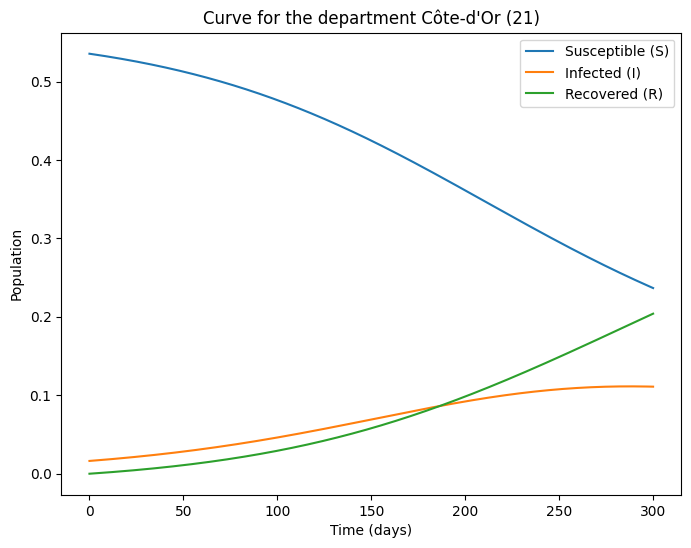

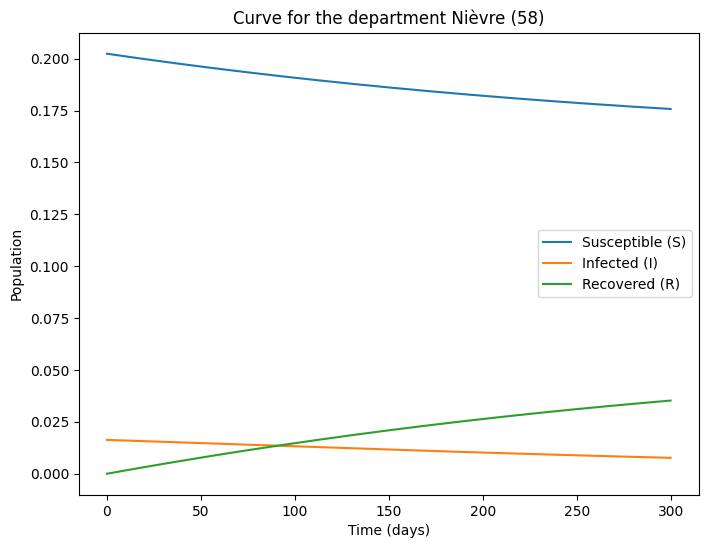

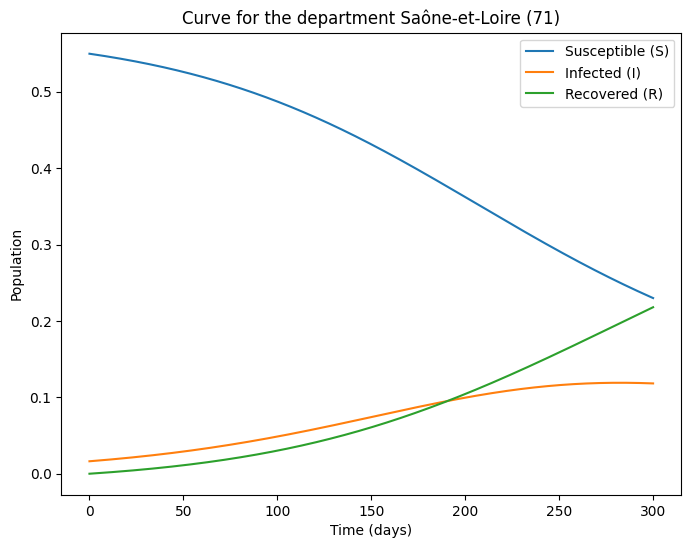

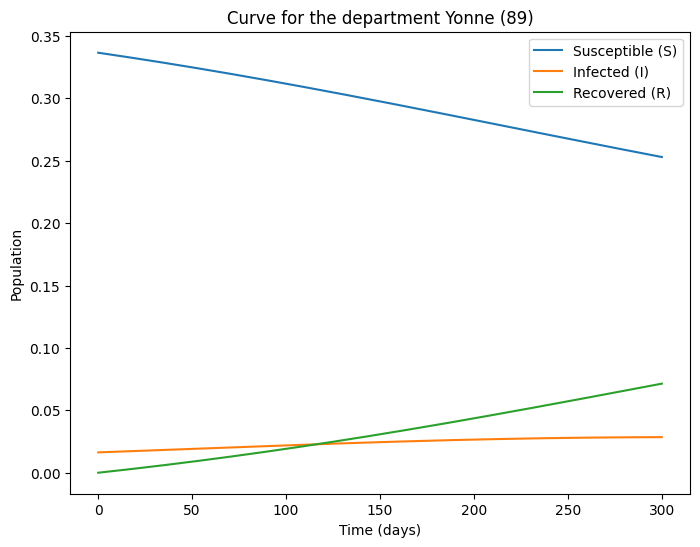

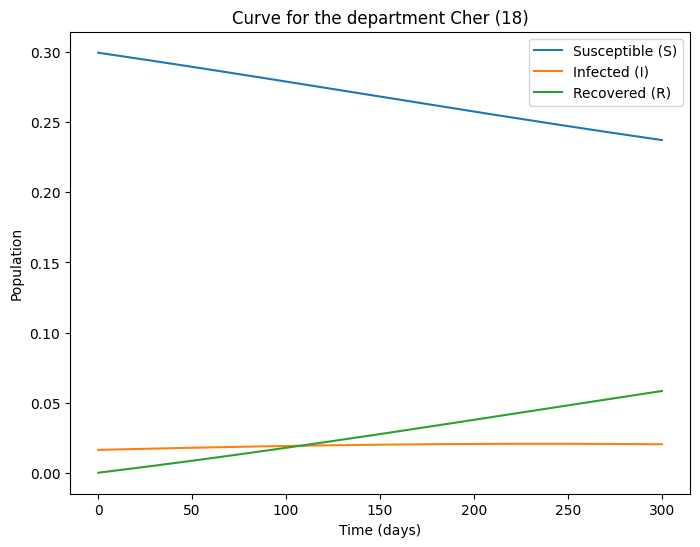

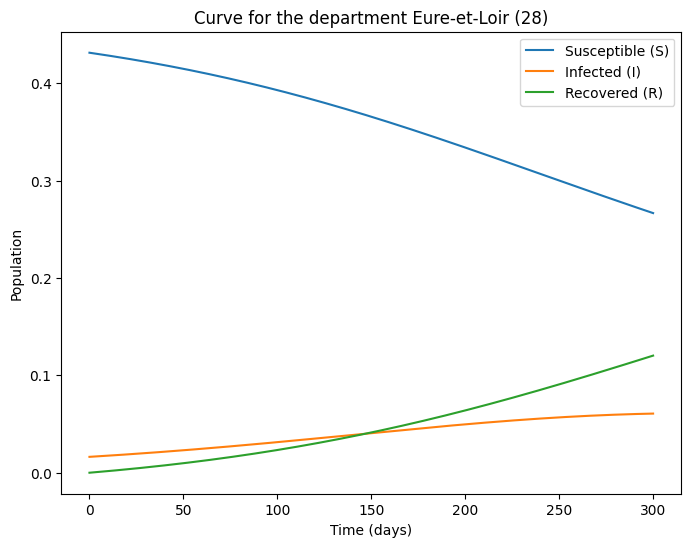

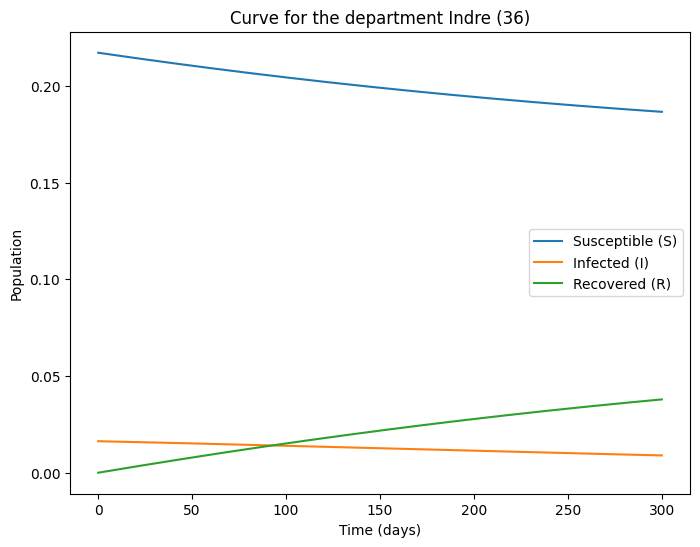

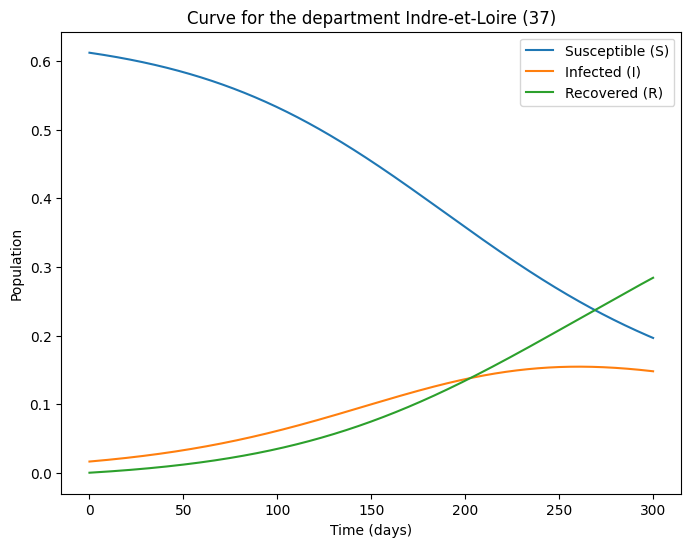

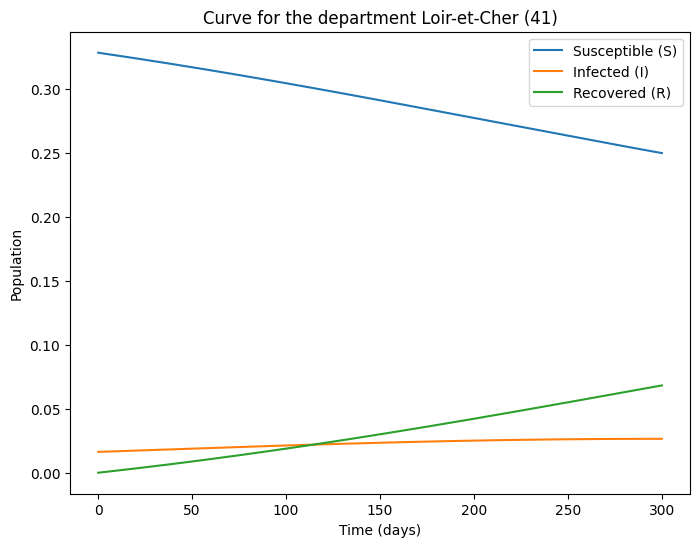

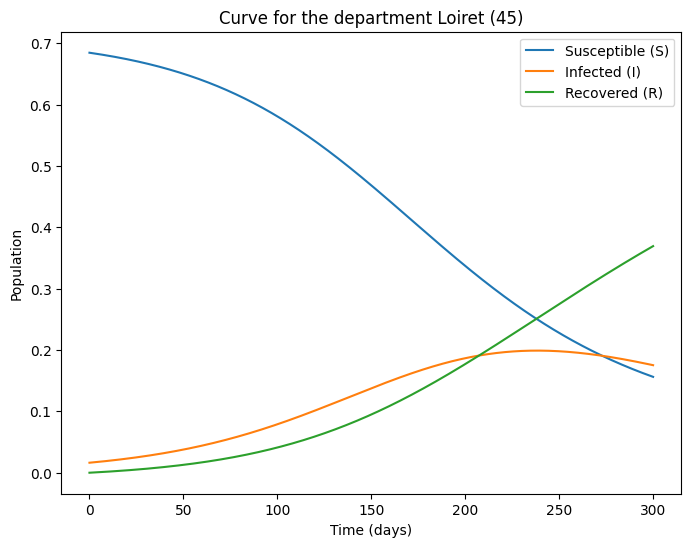

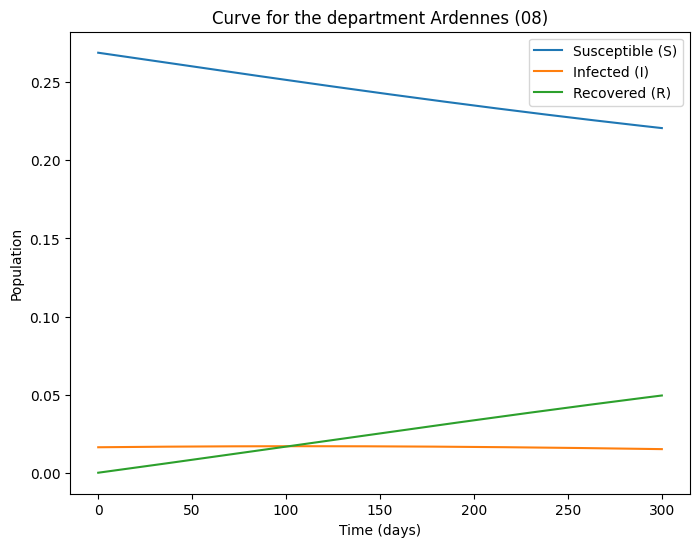

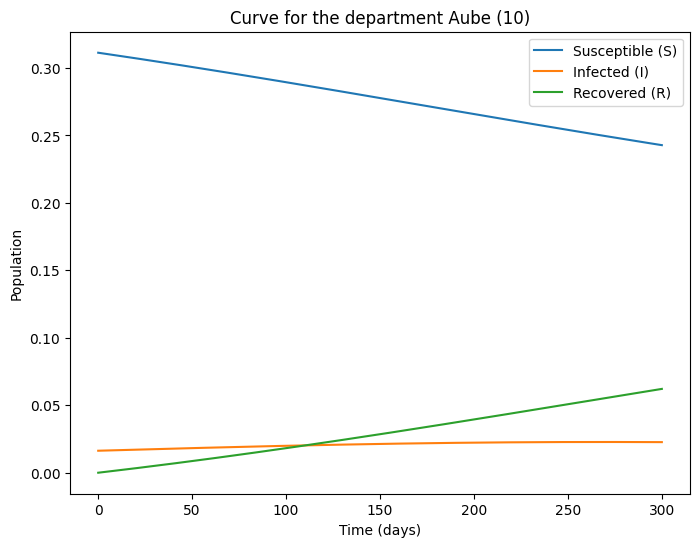

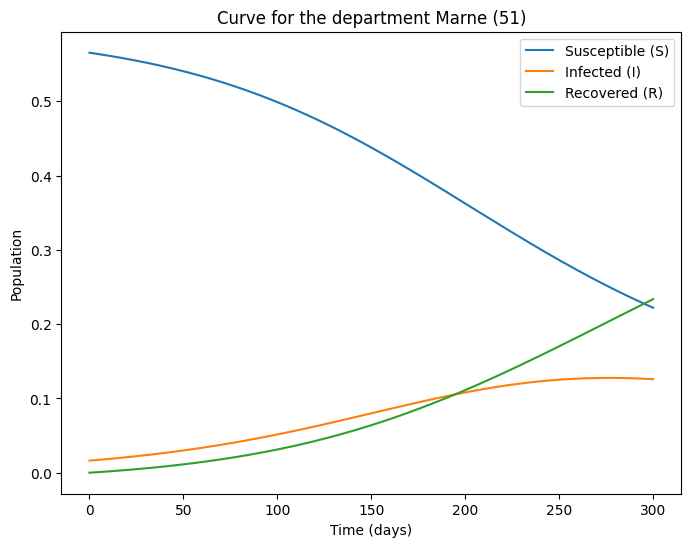

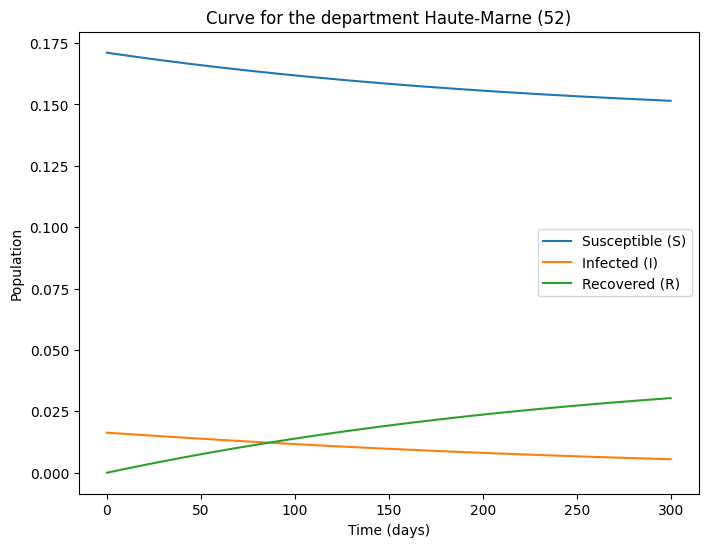

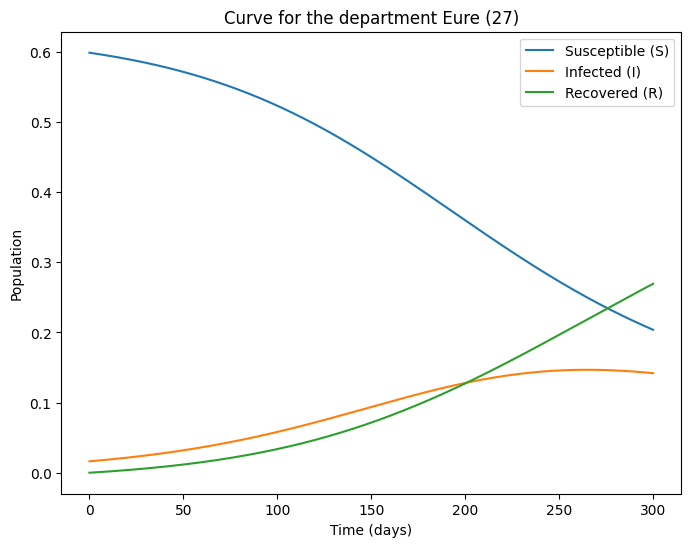

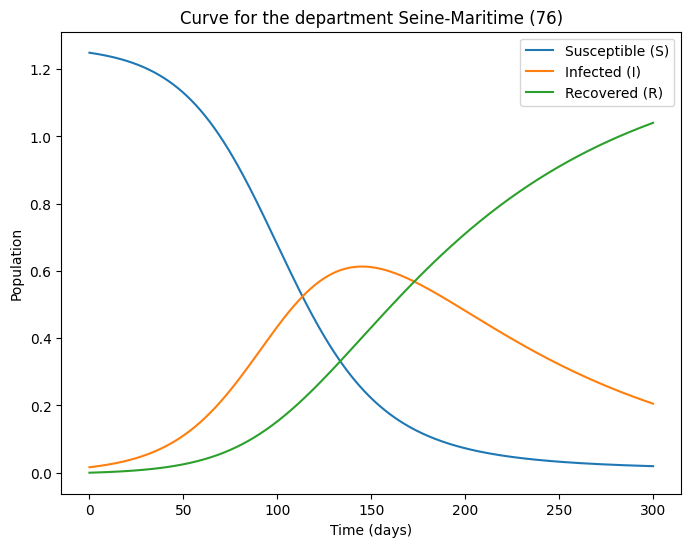

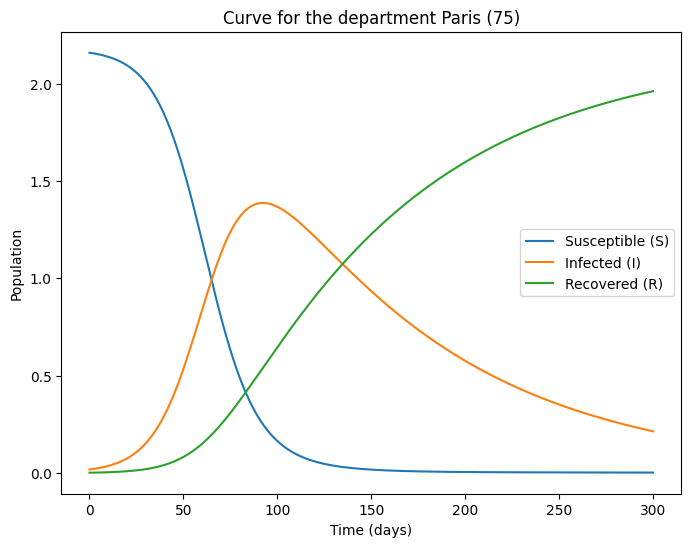

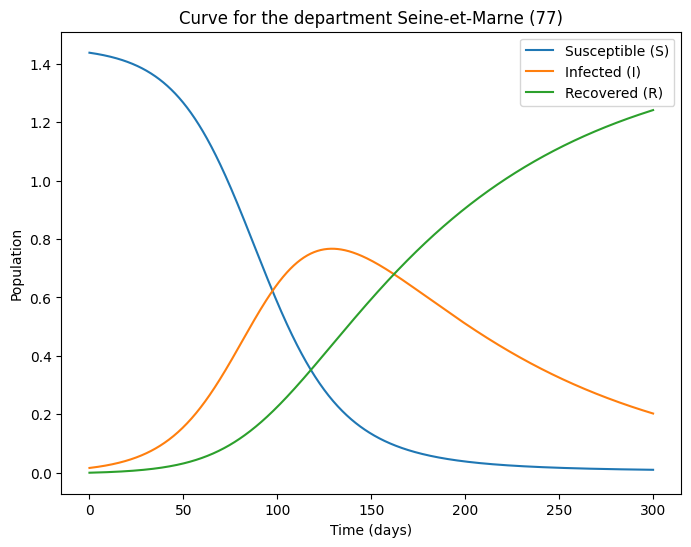

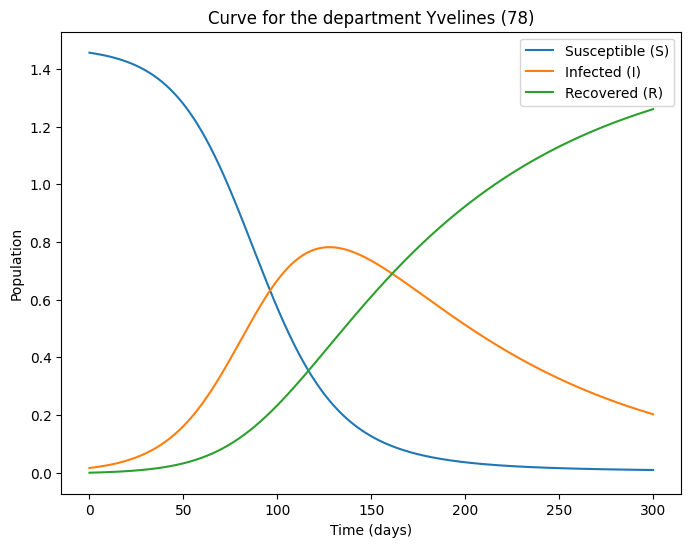

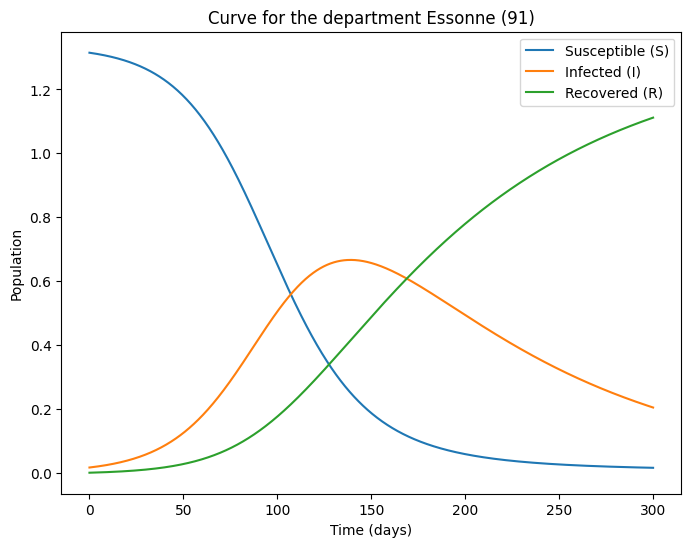

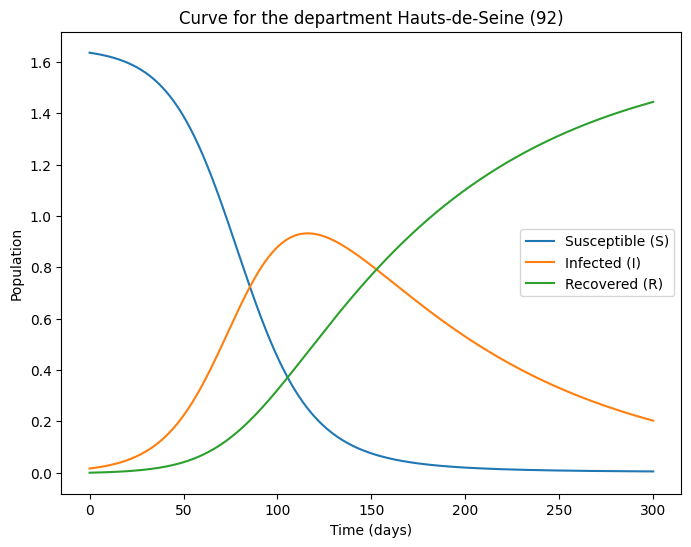

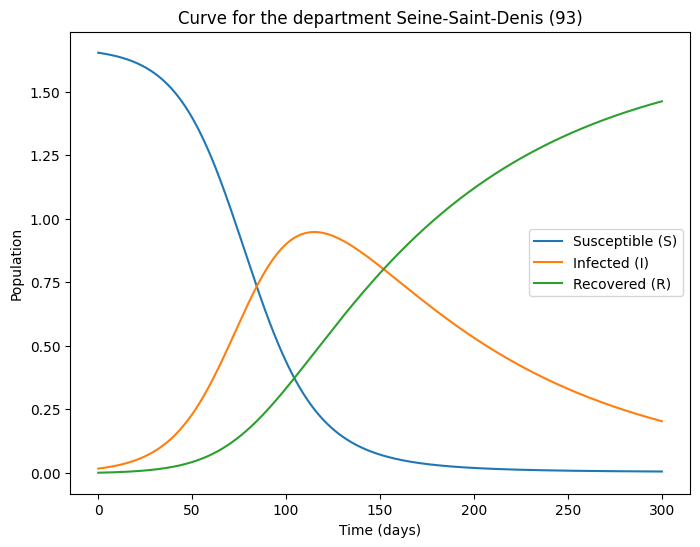

In [ ]:
def dN_dt(N, t, α, β):
    S = N[0]
    I = N[1]
    R = N[2]
    dS_dt = -α * S * I
    dI_dt = α * S * I - β * I
    dR_dt = β * I
    return np.array([dS_dt, dI_dt, dR_dt])

# Paramètres initiaux inspirés du COVID-19
nb_jours, n = 300, 1000
time = np.linspace(0, nb_jours, n)  # temps, jours
α =0.04
β = 0.01

# Information de la population pour chaque département (million)
populations = {
    'Côte-d\'Or (21)': 0.535503, 'Nièvre (58)': 0.202417, 'Saône-et-Loire (71)': 0.549763, 'Yonne (89)': 0.336532,
    'Cher (18)': 0.299573, 'Eure-et-Loir (28)': 0.431277, 'Indre (36)': 0.217228, 'Indre-et-Loire (37)': 0.612160,
    'Loir-et-Cher (41)': 0.328504, 'Loiret (45)': 0.684561, 'Ardennes (08)': 0.268859, 'Aube (10)': 0.311329,
    'Marne (51)': 0.565292, 'Haute-Marne (52)': 0.171042, 'Eure (27)': 0.598934, 'Seine-Maritime (76)': 1.249000,
    'Paris (75)': 2.161000, 'Seine-et-Marne (77)': 1.438100, 'Yvelines (78)': 1.456365, 'Essonne (91)': 1.315000,
    'Hauts-de-Seine (92)': 1.635291, 'Seine-Saint-Denis (93)': 1.654000
}


for dep, population in populations.items():
    # Initialiser les conditions initiales en fonction de la population du département
    N_i = [population, 0.0162999, 0]  # % population initiale

    # Résoudre l'équation différentielle
    solution = integrate.odeint(dN_dt, N_i, time, args=(α, β))

    # Créer un graphique avec Matplotlib
    plt.figure(figsize=(8, 6))
    plt.plot(time, solution[:, 0], label='Susceptible (S)')
    plt.plot(time, solution[:, 1], label='Infected (I)')
    plt.plot(time, solution[:, 2], label='Recovered (R)')
    plt.title(f'Curve for the department {dep}')
    plt.xlabel('Time (days)')
    plt.ylabel('Population')
    plt.legend()
    plt.show()

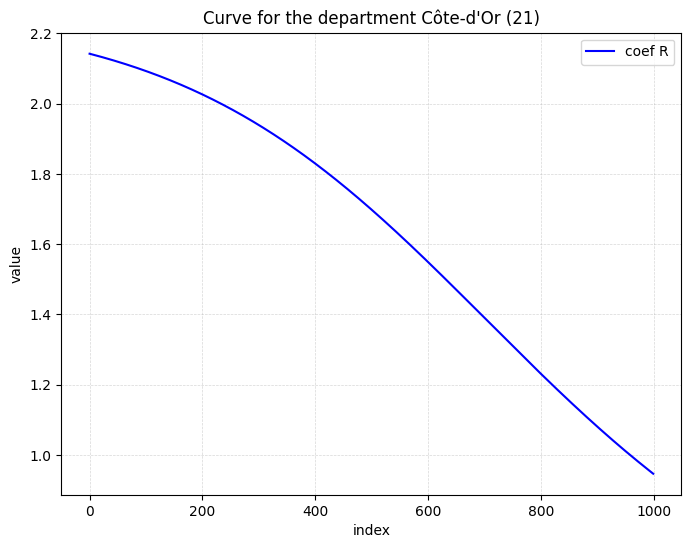

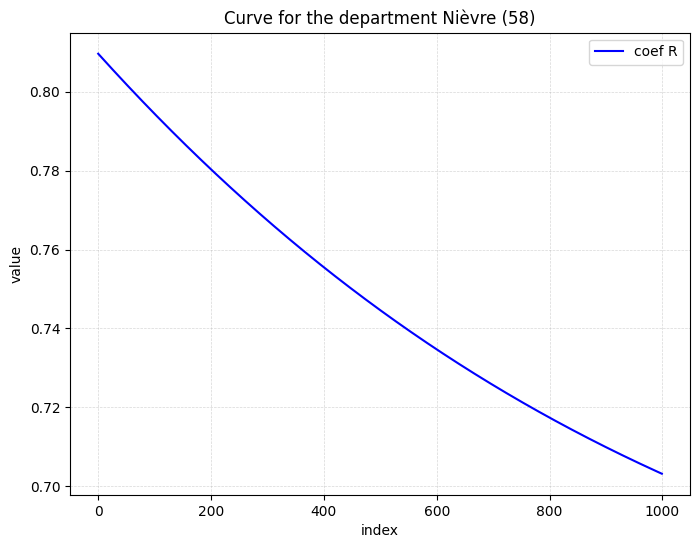

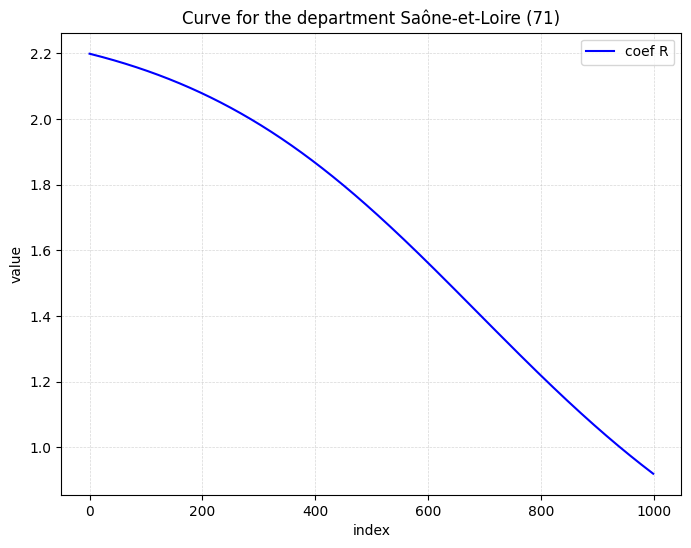

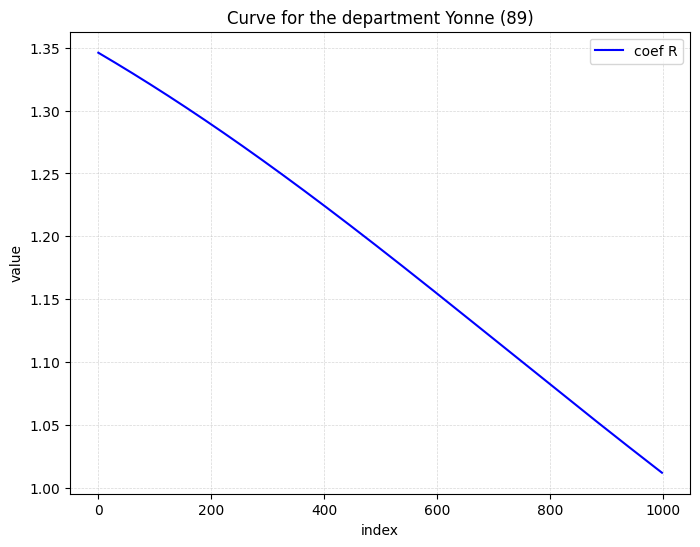

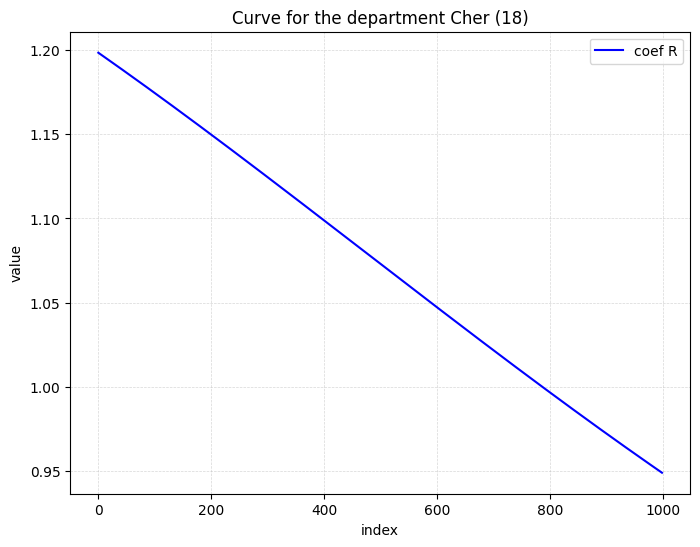

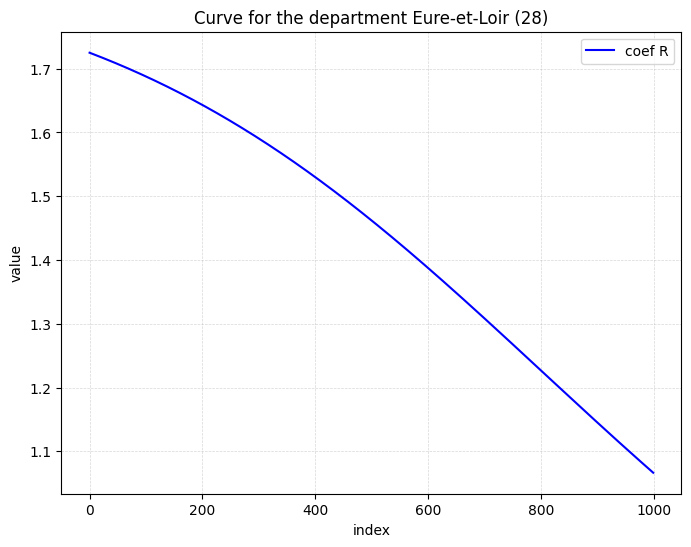

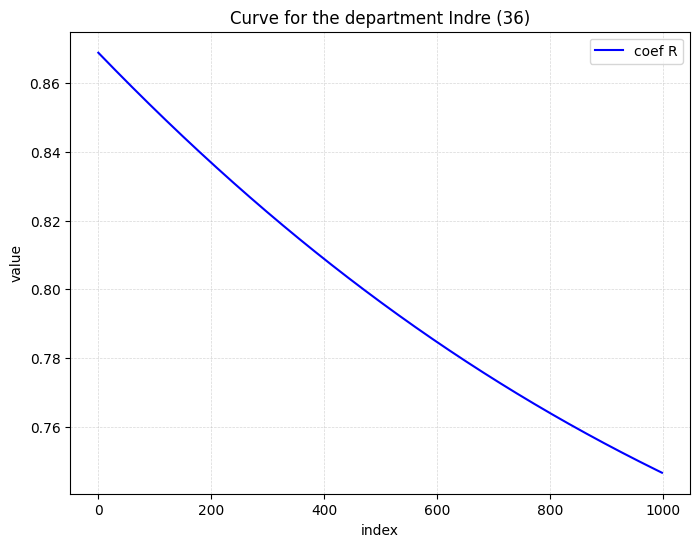

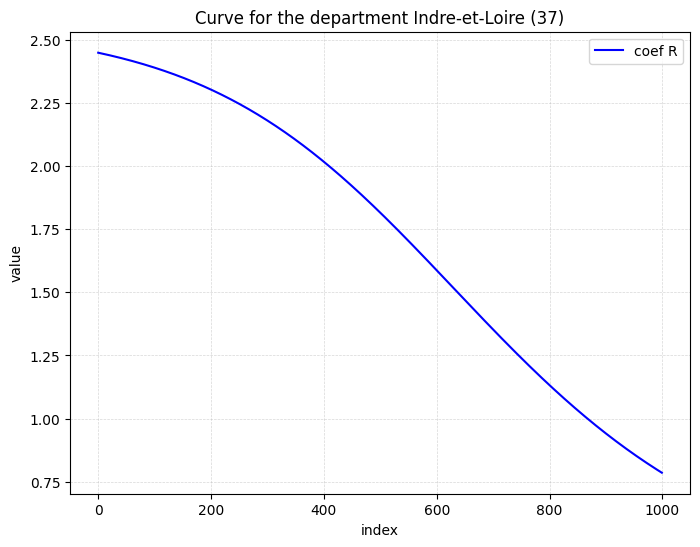

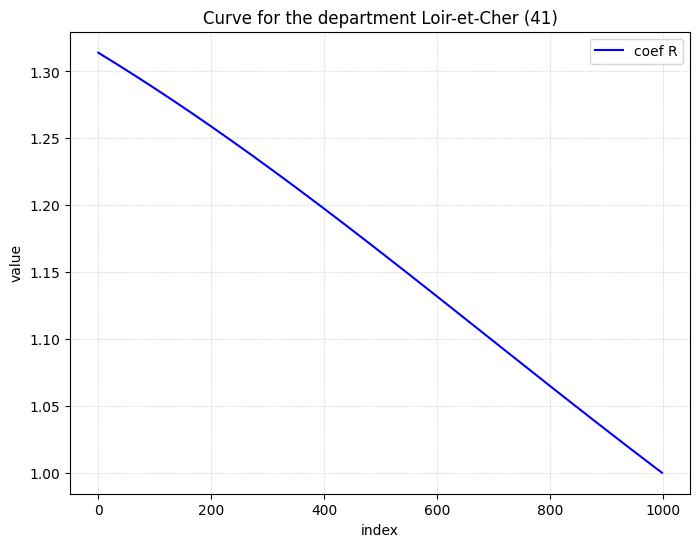

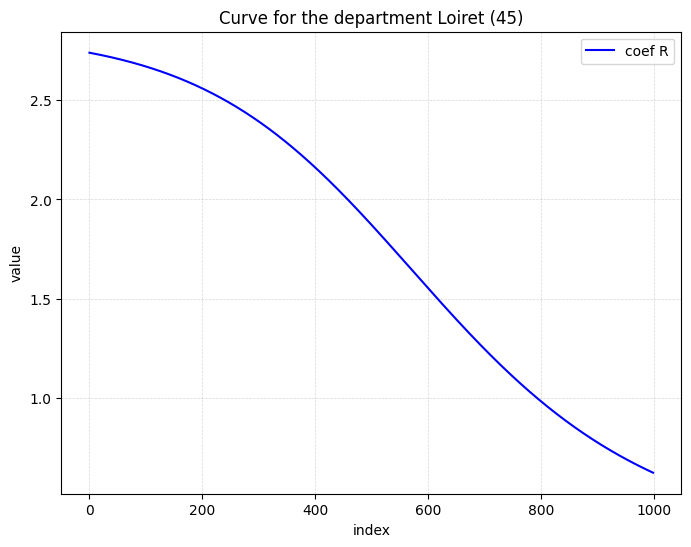

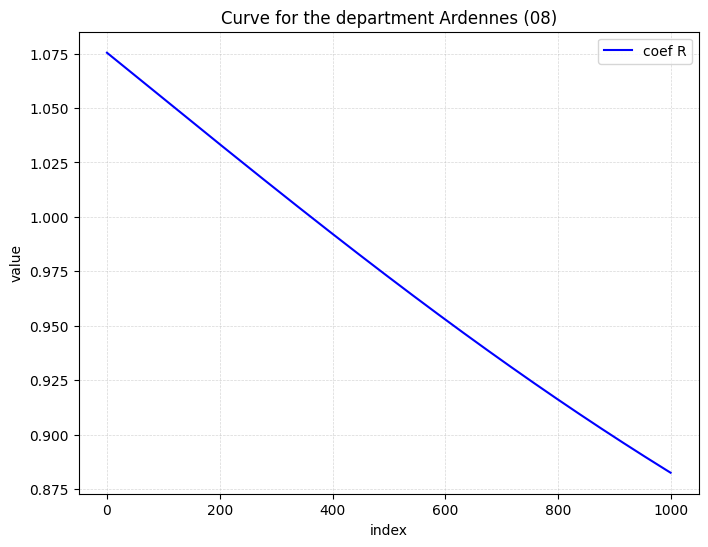

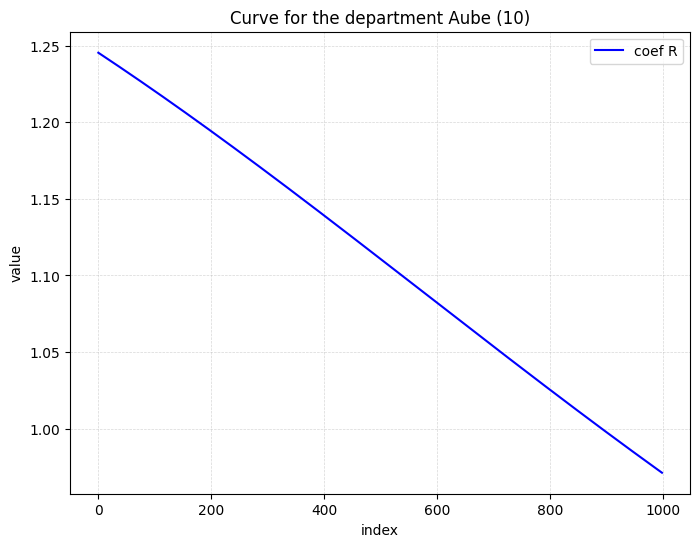

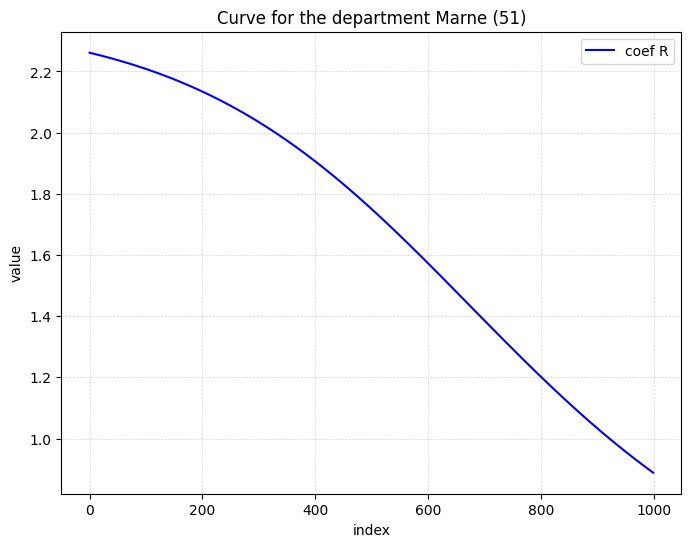

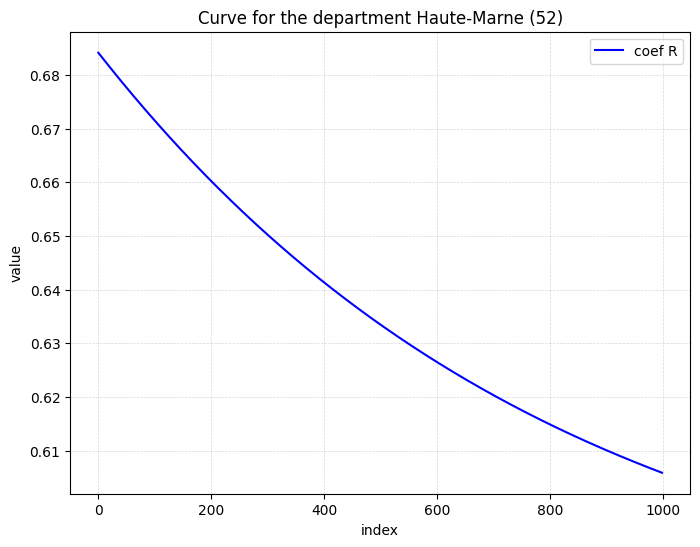

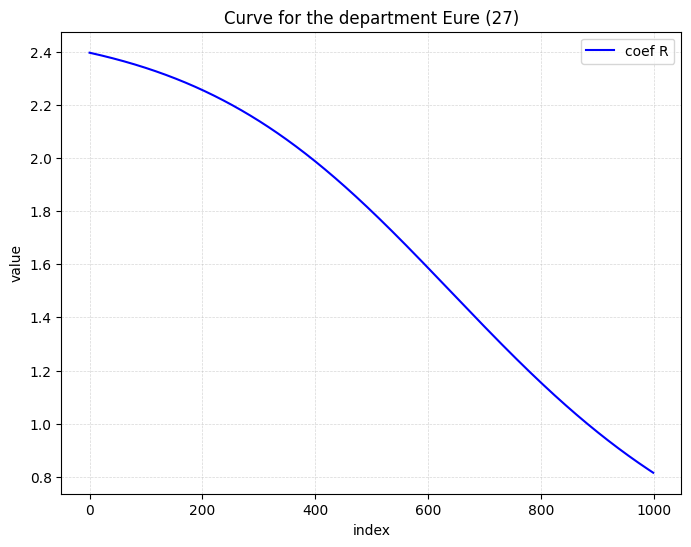

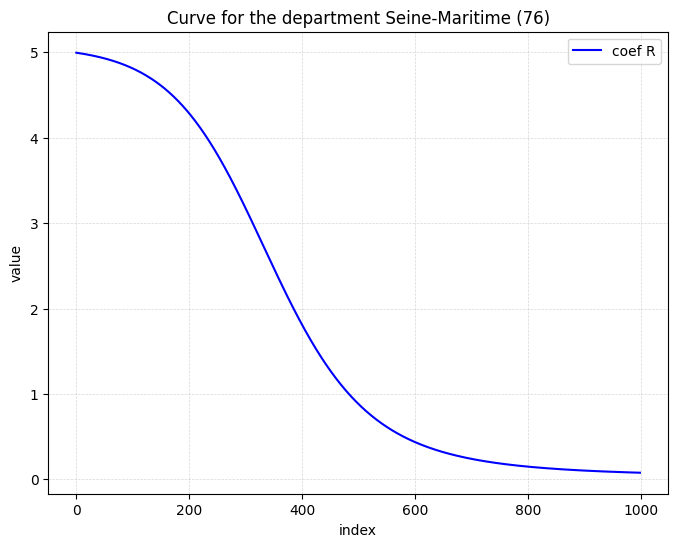

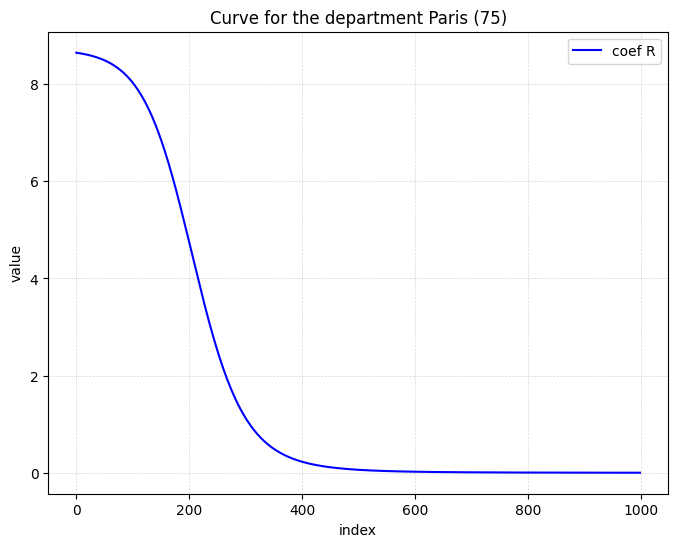

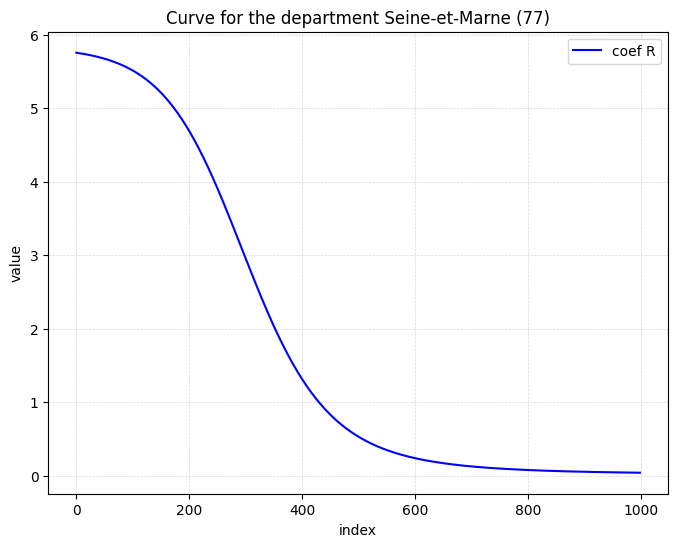

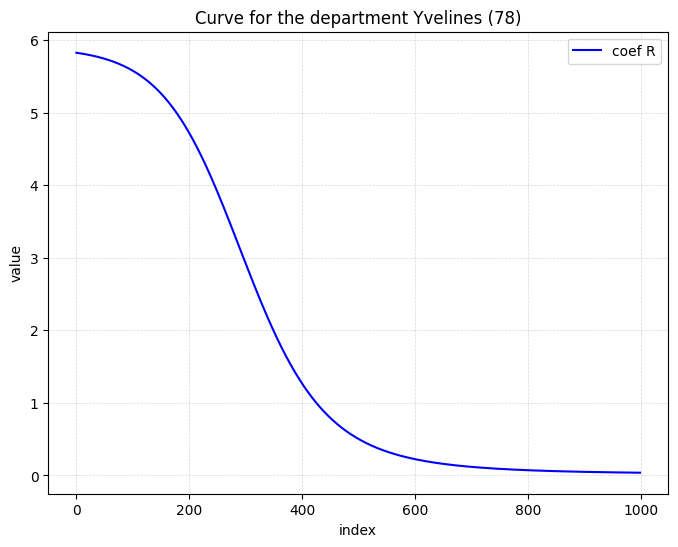

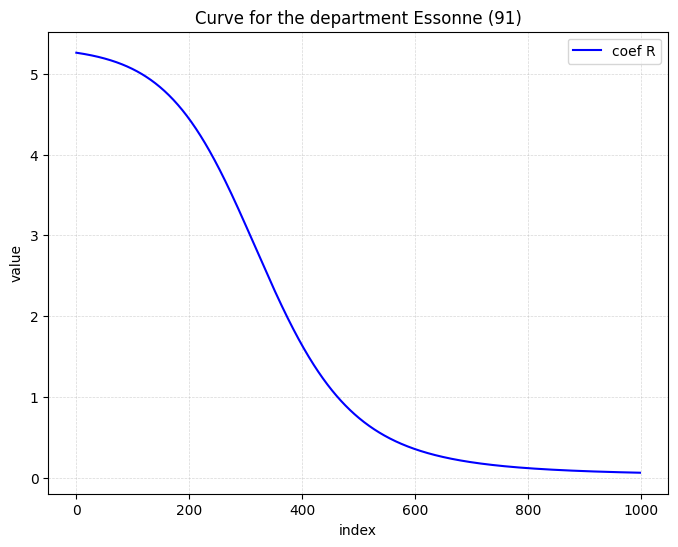

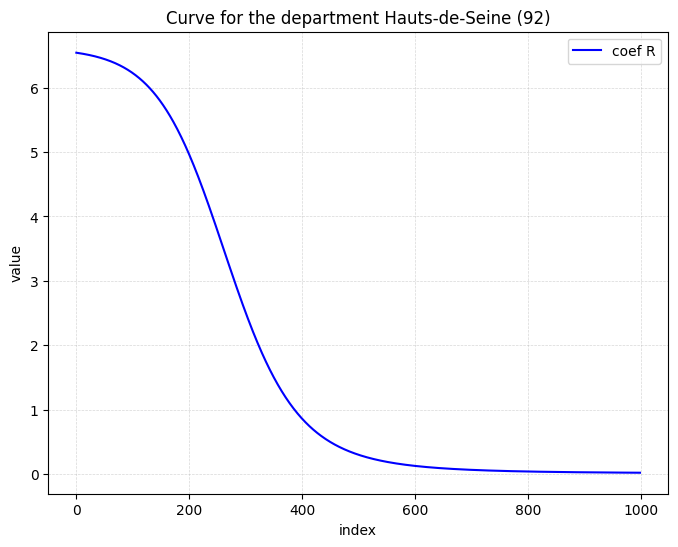

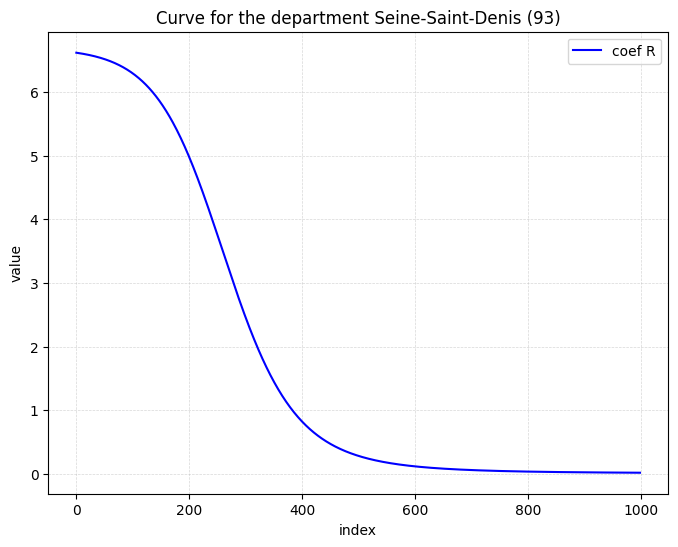

In [ ]:
def dN_dt(N, t, α, β):
    S = N[0]
    I = N[1]
    R = N[2]
    dS_dt = -α * S * I
    dI_dt = α * S * I - β * I
    dR_dt = β * I
    return np.array([dS_dt, dI_dt, dR_dt])

# Paramètres initiaux inspirés du COVID-19
nb_jours, n = 300, 1000
time = np.linspace(0, nb_jours, n)  # temps, jours
α =0.04
β = 0.01

# Information de la population pour chaque département (million)
populations = {
    'Côte-d\'Or (21)': 0.535503, 'Nièvre (58)': 0.202417, 'Saône-et-Loire (71)': 0.549763, 'Yonne (89)': 0.336532,
    'Cher (18)': 0.299573, 'Eure-et-Loir (28)': 0.431277, 'Indre (36)': 0.217228, 'Indre-et-Loire (37)': 0.612160,
    'Loir-et-Cher (41)': 0.328504, 'Loiret (45)': 0.684561, 'Ardennes (08)': 0.268859, 'Aube (10)': 0.311329,
    'Marne (51)': 0.565292, 'Haute-Marne (52)': 0.171042, 'Eure (27)': 0.598934, 'Seine-Maritime (76)': 1.249000,
    'Paris (75)': 2.161000, 'Seine-et-Marne (77)': 1.438100, 'Yvelines (78)': 1.456365, 'Essonne (91)': 1.315000,
    'Hauts-de-Seine (92)': 1.635291, 'Seine-Saint-Denis (93)': 1.654000
}


for dep, population in populations.items():
    # Initialiser les conditions initiales en fonction de la population du département
    N_i = [population, 0.0162999, 0]  # % population initiale

    # Résoudre l'équation différentielle
    solution = integrate.odeint(dN_dt, N_i, time, args=(α, β))

    S = solution[:,0]
    R = S* α / β

    R_df = pd.DataFrame({"index": np.arange(len(R)), "coef R": R})

    # Créer un graphique avec Matplotlib
    plt.figure(figsize=(8, 6))
    plt.plot(R_df["index"], R_df["coef R"], label="coef R", color="blue")
    plt.title(f'Curve for the department {dep}')
    plt.xlabel('index')
    plt.ylabel('value')
    plt.legend()
    plt.grid(linewidth=0.5, linestyle='--', which='both', axis='both', alpha=0.5)
    plt.show()

Comparaison de la courbe de $I$ du modèle SIR avec la courbe réélle des cas

DataFrame pour le Département 21 :


<ipython-input-102-c901c19ec469>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solution_df_r = solution_df[1000:2000].append(data_r)


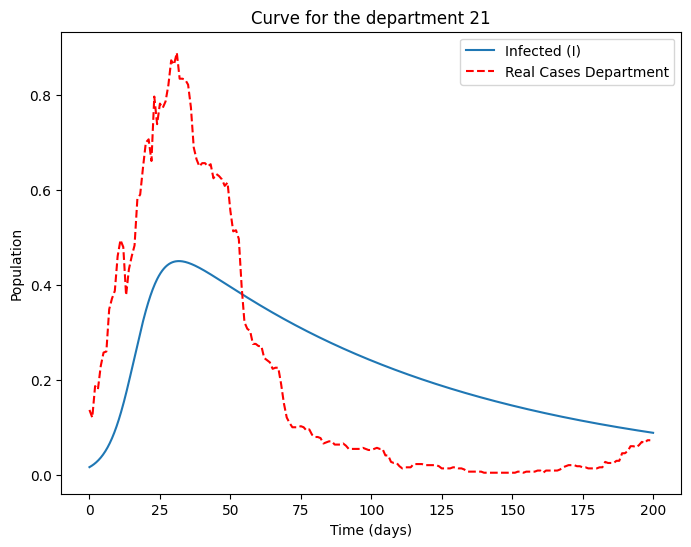

DataFrame pour le Département 58 :


<ipython-input-102-c901c19ec469>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solution_df_r = solution_df[1000:2000].append(data_r)


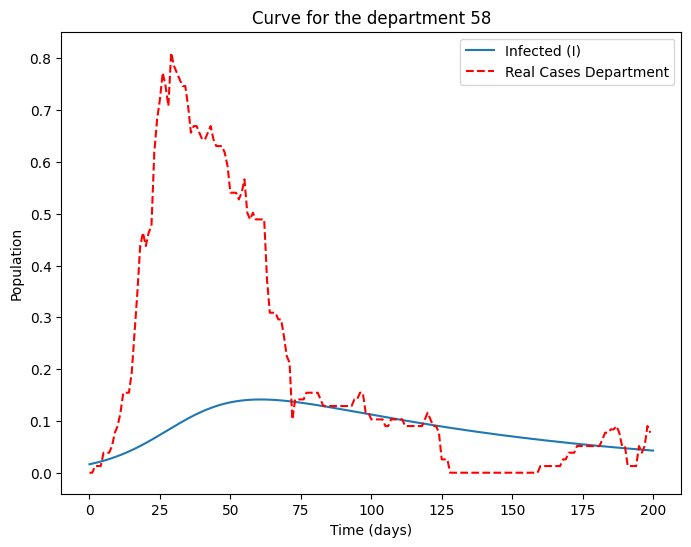

DataFrame pour le Département 71 :


<ipython-input-102-c901c19ec469>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solution_df_r = solution_df[1000:2000].append(data_r)


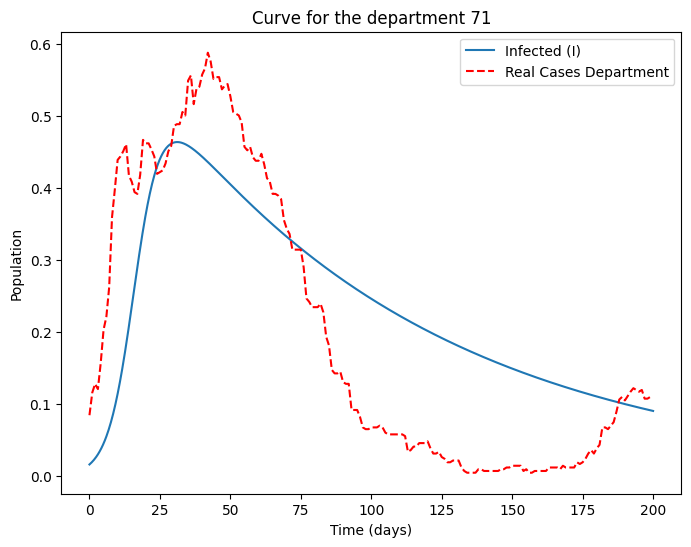

DataFrame pour le Département 89 :


<ipython-input-102-c901c19ec469>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solution_df_r = solution_df[1000:2000].append(data_r)


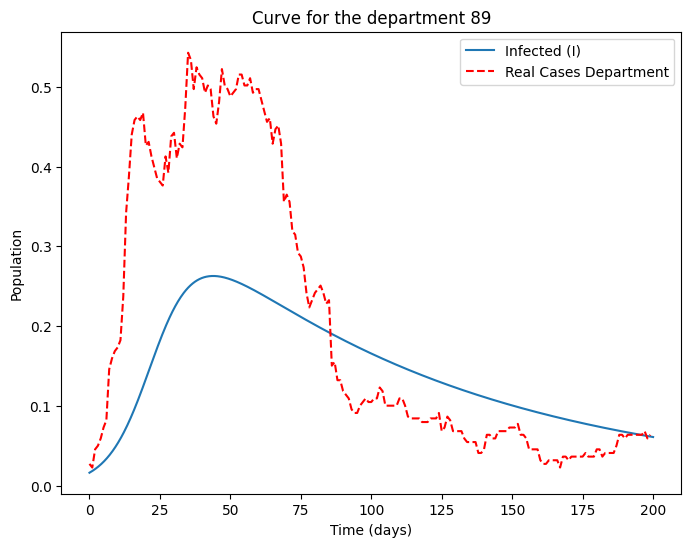

DataFrame pour le Département 18 :


<ipython-input-102-c901c19ec469>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solution_df_r = solution_df[1000:2000].append(data_r)


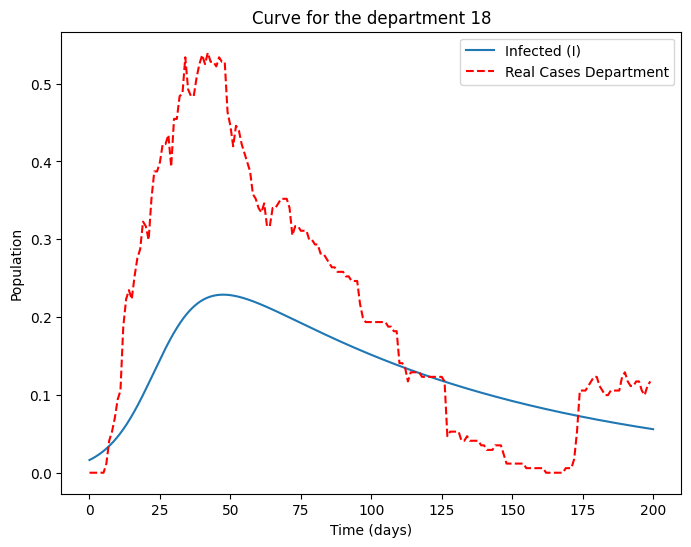

DataFrame pour le Département 28 :


<ipython-input-102-c901c19ec469>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solution_df_r = solution_df[1000:2000].append(data_r)


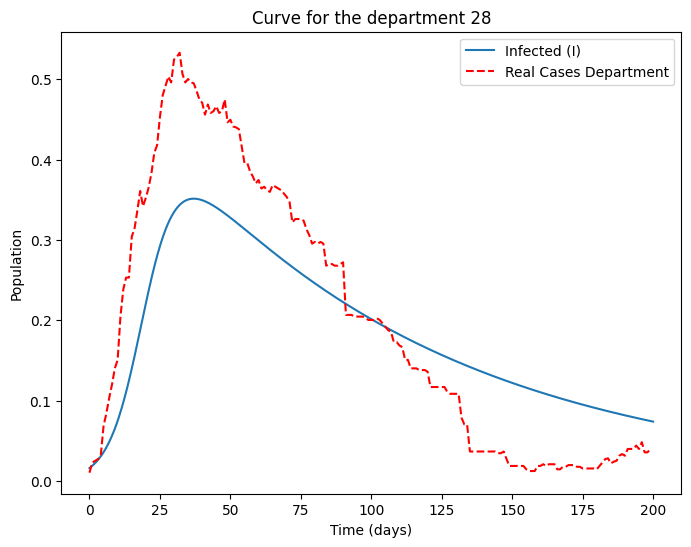

DataFrame pour le Département 36 :


<ipython-input-102-c901c19ec469>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solution_df_r = solution_df[1000:2000].append(data_r)


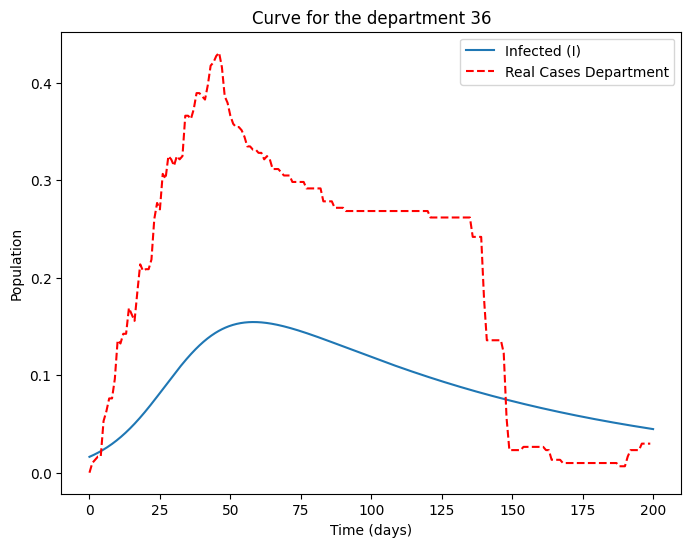

DataFrame pour le Département 37 :


<ipython-input-102-c901c19ec469>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solution_df_r = solution_df[1000:2000].append(data_r)


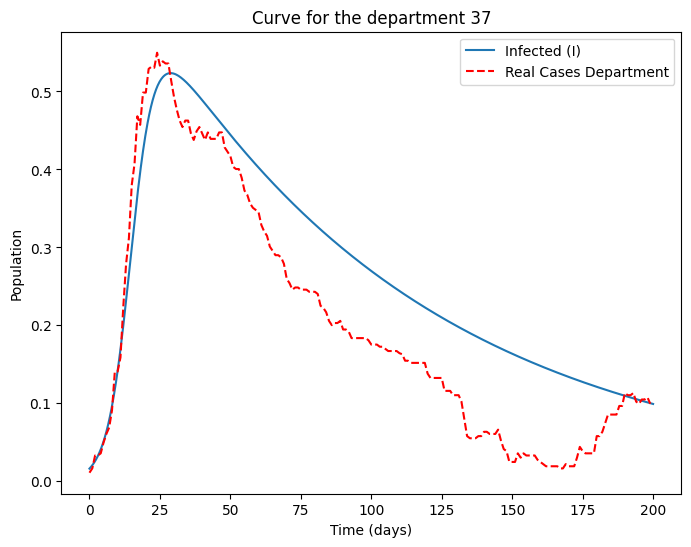

DataFrame pour le Département 41 :


<ipython-input-102-c901c19ec469>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solution_df_r = solution_df[1000:2000].append(data_r)


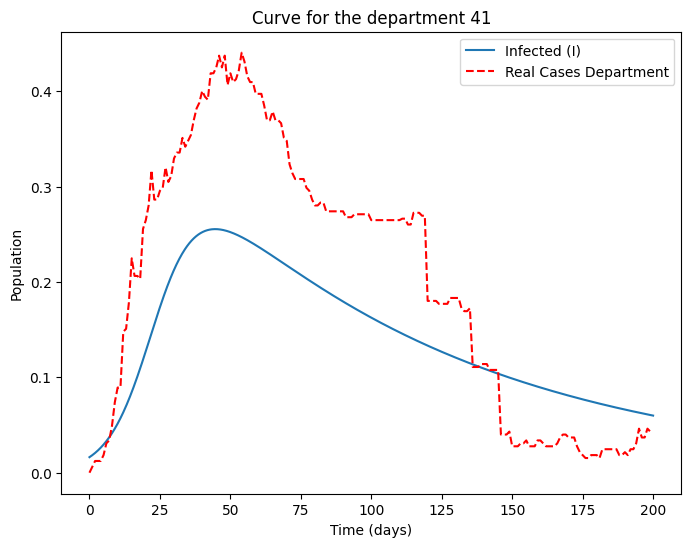

DataFrame pour le Département 45 :


<ipython-input-102-c901c19ec469>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solution_df_r = solution_df[1000:2000].append(data_r)


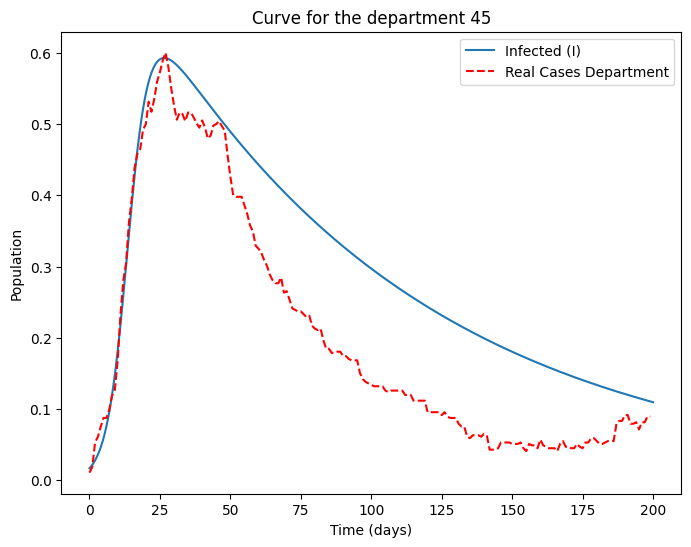

DataFrame pour le Département 8 :


<ipython-input-102-c901c19ec469>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solution_df_r = solution_df[1000:2000].append(data_r)


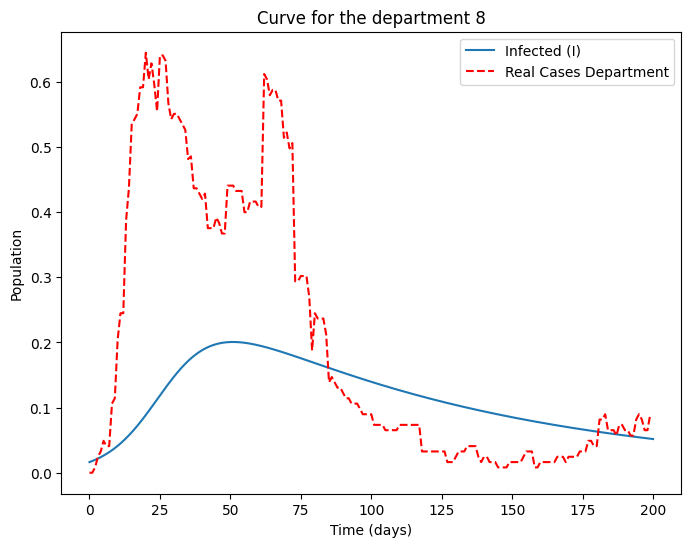

DataFrame pour le Département 10 :


<ipython-input-102-c901c19ec469>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solution_df_r = solution_df[1000:2000].append(data_r)


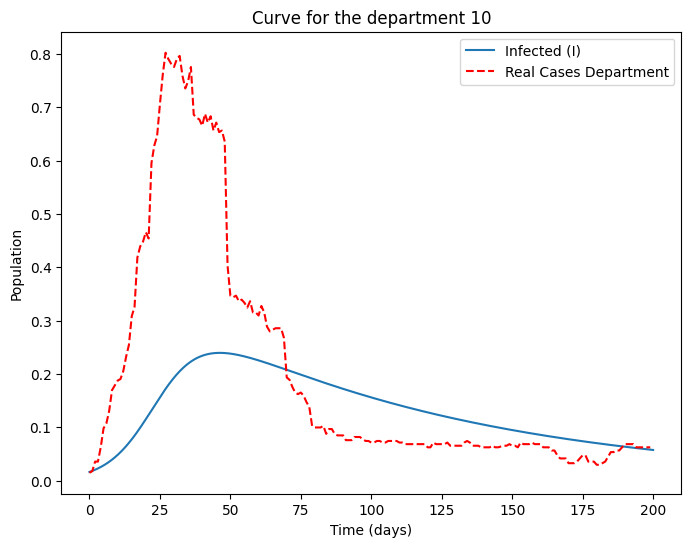

DataFrame pour le Département 51 :


<ipython-input-102-c901c19ec469>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solution_df_r = solution_df[1000:2000].append(data_r)


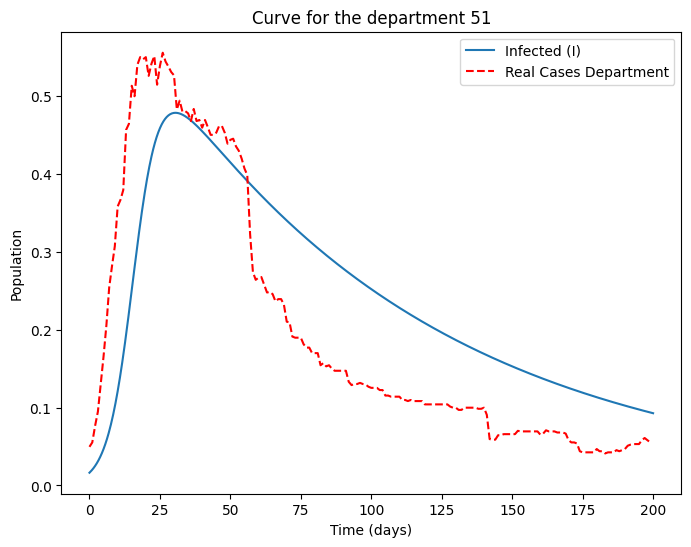

DataFrame pour le Département 52 :


<ipython-input-102-c901c19ec469>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solution_df_r = solution_df[1000:2000].append(data_r)


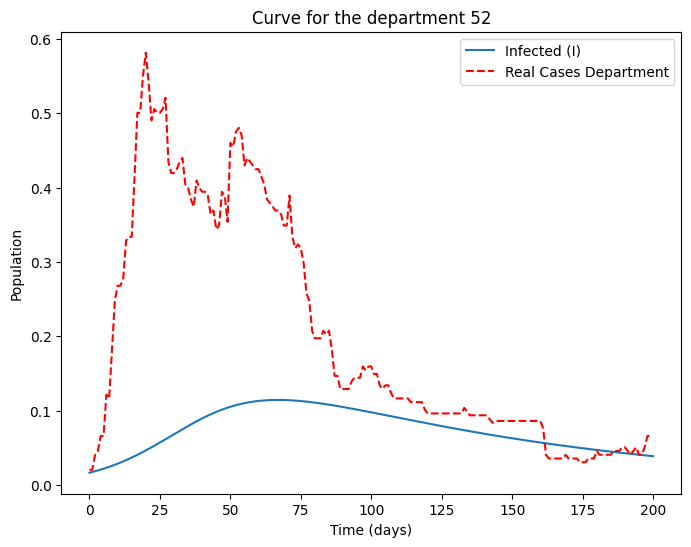

DataFrame pour le Département 27 :


<ipython-input-102-c901c19ec469>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solution_df_r = solution_df[1000:2000].append(data_r)


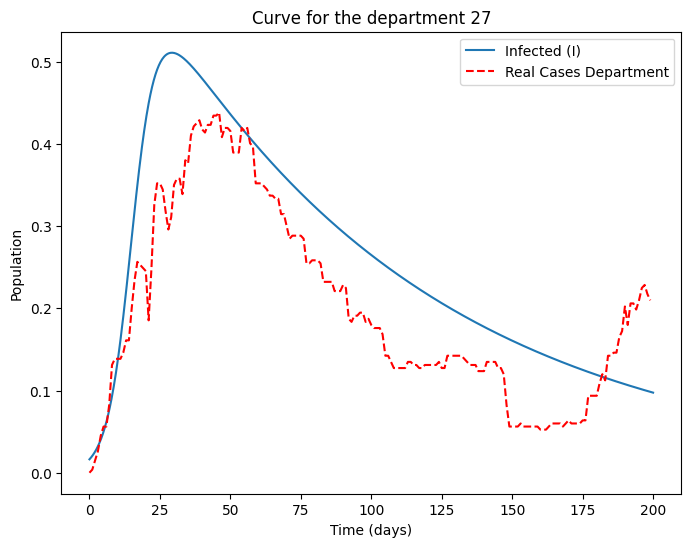

DataFrame pour le Département 76 :


<ipython-input-102-c901c19ec469>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solution_df_r = solution_df[1000:2000].append(data_r)


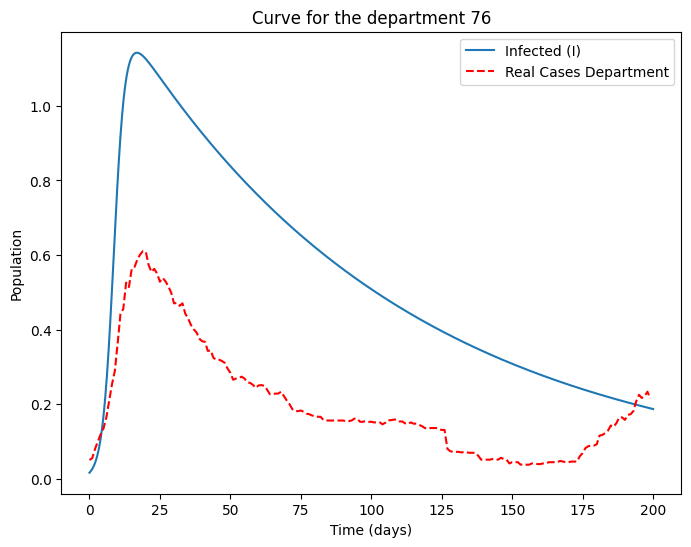

DataFrame pour le Département 75 :


<ipython-input-102-c901c19ec469>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solution_df_r = solution_df[1000:2000].append(data_r)


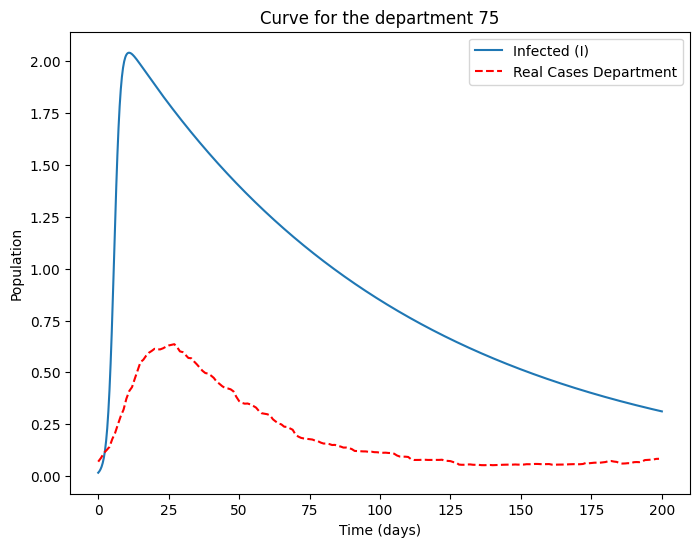

DataFrame pour le Département 77 :


<ipython-input-102-c901c19ec469>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solution_df_r = solution_df[1000:2000].append(data_r)


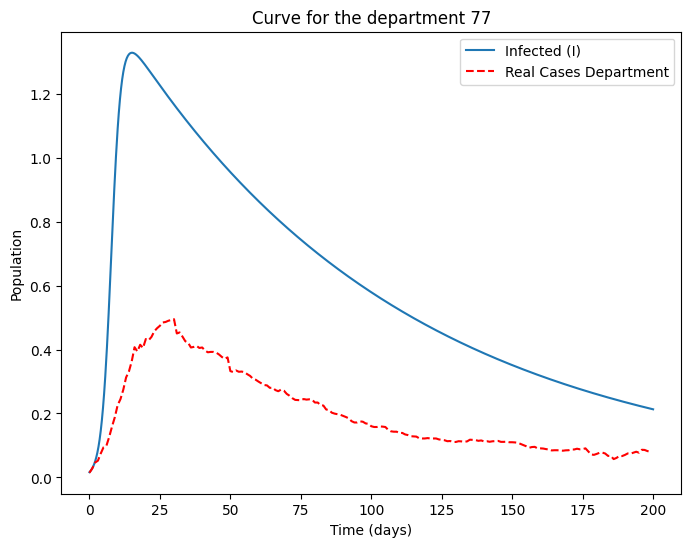

DataFrame pour le Département 78 :


<ipython-input-102-c901c19ec469>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solution_df_r = solution_df[1000:2000].append(data_r)


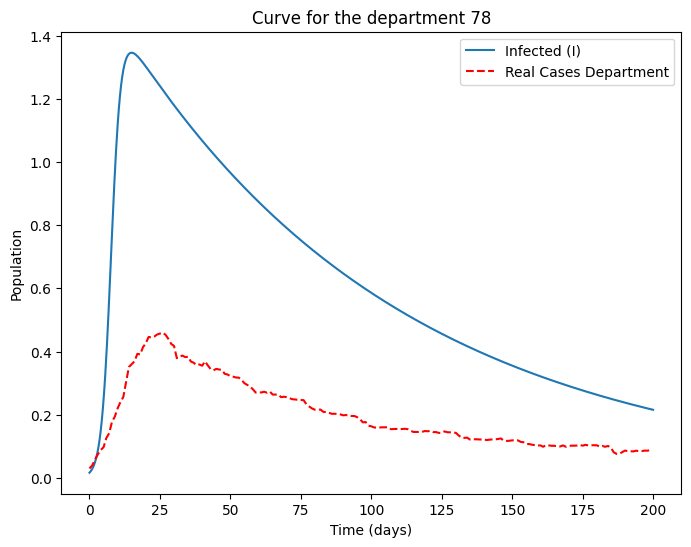

DataFrame pour le Département 91 :


<ipython-input-102-c901c19ec469>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solution_df_r = solution_df[1000:2000].append(data_r)


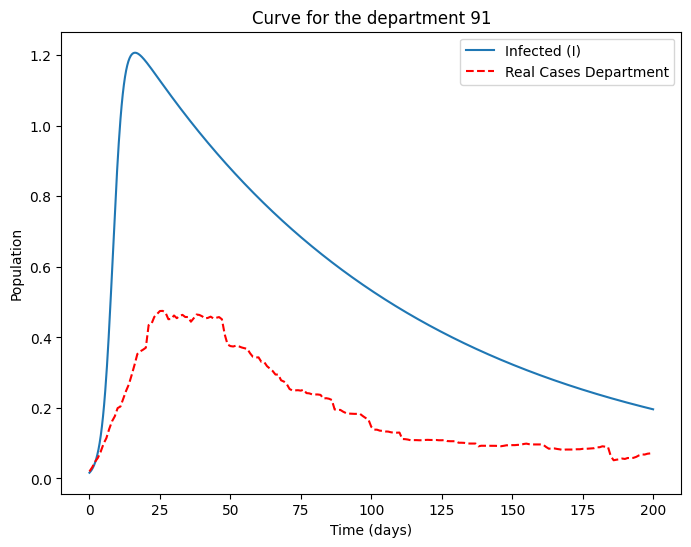

DataFrame pour le Département 92 :


<ipython-input-102-c901c19ec469>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solution_df_r = solution_df[1000:2000].append(data_r)


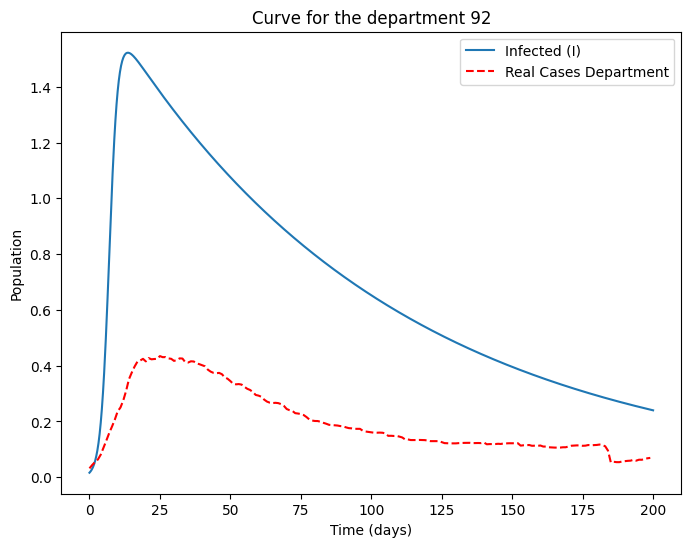

DataFrame pour le Département 93 :


<ipython-input-102-c901c19ec469>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solution_df_r = solution_df[1000:2000].append(data_r)


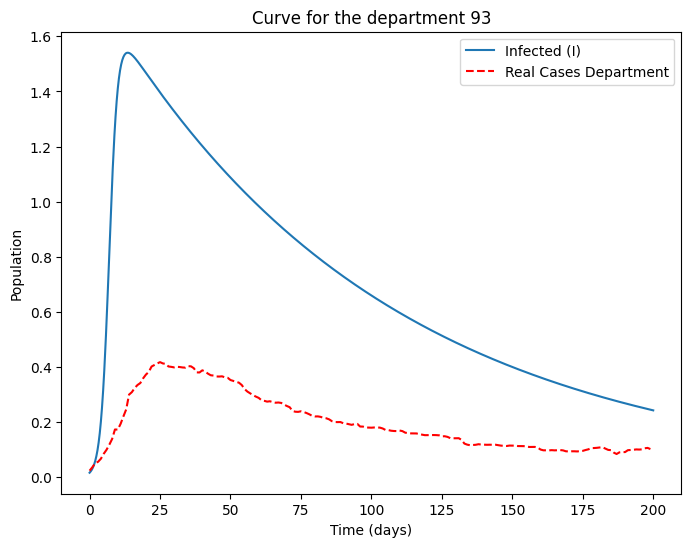

DataFrame pour le Département 94 :


<ipython-input-102-c901c19ec469>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solution_df_r = solution_df[1000:2000].append(data_r)


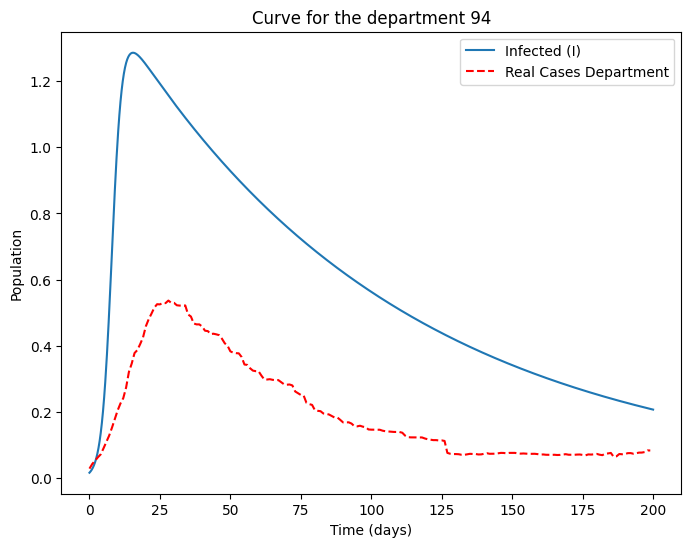

DataFrame pour le Département 95 :


<ipython-input-102-c901c19ec469>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solution_df_r = solution_df[1000:2000].append(data_r)


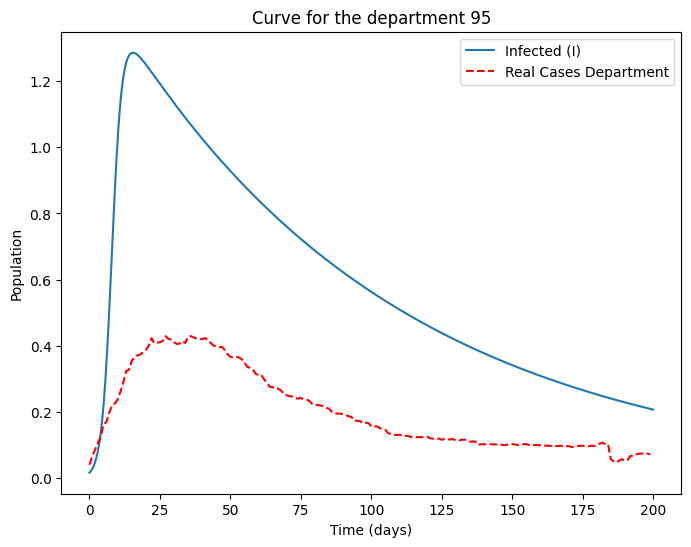

DataFrame pour le Département 2 :


<ipython-input-102-c901c19ec469>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solution_df_r = solution_df[1000:2000].append(data_r)


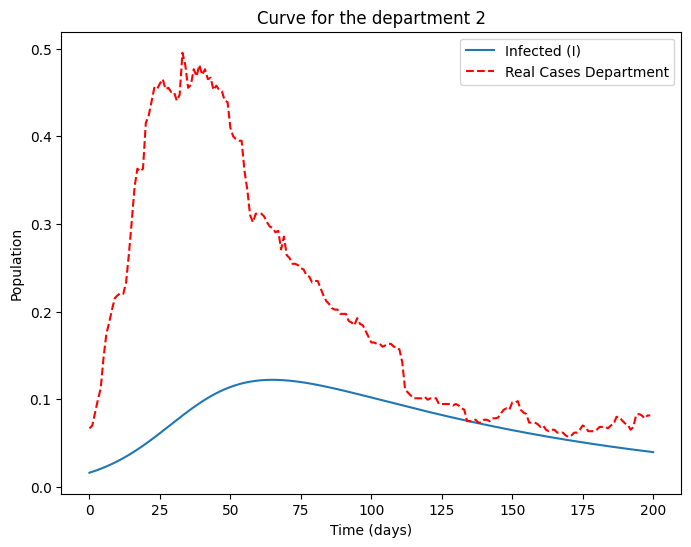

DataFrame pour le Département 60 :


<ipython-input-102-c901c19ec469>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solution_df_r = solution_df[1000:2000].append(data_r)


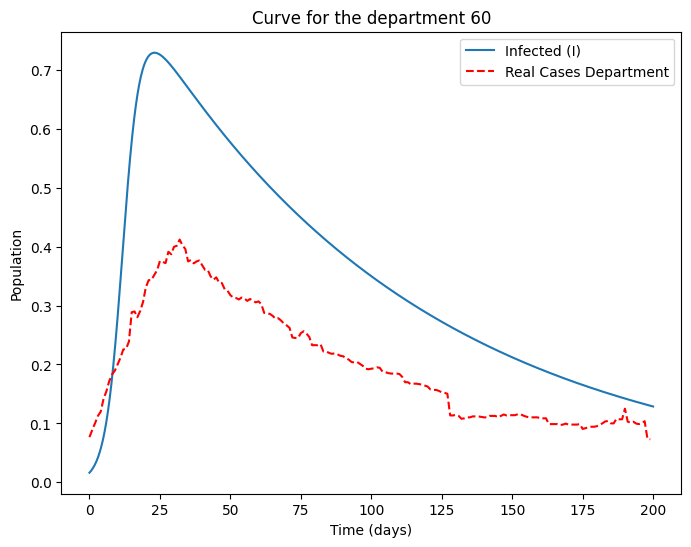

DataFrame pour le Département 80 :


<ipython-input-102-c901c19ec469>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  solution_df_r = solution_df[1000:2000].append(data_r)


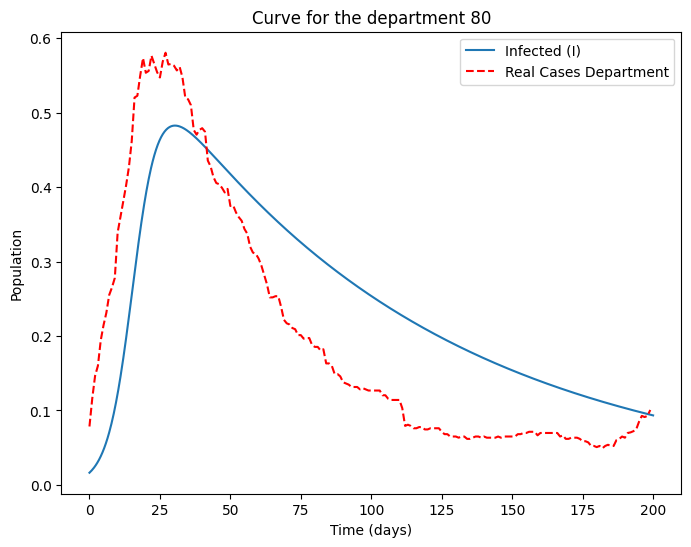

In [ ]:
def dN_dt(N, t, α, β):
    S = N[0]
    I = N[1]
    R = N[2]
    dS_dt = -α * S * I
    dI_dt = α * S * I - β * I
    dR_dt = β * I
    return np.array([dS_dt, dI_dt, dR_dt])

# Paramètres initiaux inspirés du COVID-19
nb_jours, n = 200, 1000
time = np.linspace(0, nb_jours, n)  # temps, jours
α =0.4
β = 0.01

populations = {
    21: 0.535503, 58: 0.202417, 71: 0.549763, 89: 0.336532,
    18: 0.299573, 28: 0.431277, 36: 0.217228, 37: 0.612160,
    41: 0.328504, 45: 0.684561, 8: 0.268859, 10: 0.311329,
    51: 0.565292, 52: 0.171042, 27: 0.598934, 76: 1.249000,
    75: 2.161000, 77: 1.438100, 78: 1.456365, 91: 1.315000,
    92: 1.635291, 93: 1.654000, 2 : 0.180378, 94: 1.395, 95 : 1.395, 60: 0.825207, 80 : 0.569662
}

datasets_par_departement = {}

# Itérer sur les codes de département
for dep in departements_souhaites:
  # Filtrer le DataFrame pour le département actuel
  departement_df = df[df['dep'] == dep]
  # Stocker le DataFrame dans le dictionnaire, en utilisant le code du département comme clé
  datasets_par_departement[dep] = departement_df

retard = 150

for dep, dataframe in datasets_par_departement.items():
    print(f"DataFrame pour le Département {dep} :")
    dataframe = dataframe.groupby('jour')['nombre_de_cas'].sum().reset_index()
    dataframe = dataframe['nombre_de_cas'].to_frame()
    population = populations.get(int(dep))
    dataframe['population'] = population
    datasets_par_departement[dep] = dataframe
    dataframe = dataframe.iloc[0:200]

    z_dep = np.array(dataframe['nombre_de_cas'].tolist())
    z_dep = z_dep * (40/sum(z_dep))

    # Initialiser les conditions initiales en fonction de la population du département
    N_i = [population, 0.0162999, 0]  # % population initiale

    # Résoudre l'équation différentielle
    solution = integrate.odeint(dN_dt, N_i, time, args=(α, β))

    solution_df = pd.DataFrame(solution, columns = ["S", "I", "R"], index = time).reset_index()
    solution_df = pd.melt(solution_df, id_vars="index")

    index_r = solution_df["index"].tolist()[:n]
    value_r = [None] * retard + [z_dep[int(index_r[i - retard])] for i in range(retard, n)]

    data_r = pd.DataFrame(
        {
            "index": index_r,
            "variable": ["Cas Réels"] * n,
            "value": value_r,
        }
    )

    solution_df_r = solution_df[1000:2000].append(data_r)

    # Créer un graphique avec Matplotlib
    plt.figure(figsize=(8, 6))
    plt.plot(time, solution[:, 1], label='Infected (I)')
    #plt.plot(solution_df_r['index'], solution_df_r['value'], label='Cas Réels', linestyle='dashed', color='black')
    plt.plot(dataframe.index, z_dep, label='Real Cases Department', linestyle='dashed', color='red')

    plt.title(f'Curve for the department {dep}')
    plt.xlabel('Time (days)')
    plt.ylabel('Population')
    plt.legend()
    plt.show()

In [ ]:
def database():

    """filtrage de la base de données des cas de covid dans chaque région
    donne en sortie un data frame de 2 colonnes; date et nombre de cas"""

    df_hospit=pd.read_csv('./covid-hospit.csv', sep= ';')

    df_idf = df_hospit[(df_hospit.dep == '75') | (df_hospit.dep == '77') |(df_hospit.dep == '78') |(df_hospit.dep == '91') |(df_hospit.dep == '92') |(df_hospit.dep == '93') |(df_hospit.dep == '94') |(df_hospit.dep == '95')].groupby('jour')['hosp'].sum()
    df_bourgogne = df_hospit[(df_hospit.dep == '21') | (df_hospit.dep == '58') |(df_hospit.dep == '71') |(df_hospit.dep == '89')].groupby('jour')['hosp'].sum()
    df_centre = df_hospit[(df_hospit.dep == '18') | (df_hospit.dep == '28') |(df_hospit.dep == '36') |(df_hospit.dep == '37') |(df_hospit.dep == '41') |(df_hospit.dep == '45')].groupby('jour')['hosp'].sum()
    df_champagne = df_hospit[(df_hospit.dep == '8') | (df_hospit.dep == '10') |(df_hospit.dep == '51') |(df_hospit.dep == '52')].groupby('jour')['hosp'].sum()
    df_h_normandie = df_hospit[(df_hospit.dep == '27') | (df_hospit.dep == '76')].groupby('jour')['hosp'].sum()
    df_picardie = df_hospit[(df_hospit.dep == '2') | (df_hospit.dep == '60') |(df_hospit.dep == '80')].groupby('jour')['hosp'].sum()
    return [df_bourgogne,df_centre,df_champagne,df_h_normandie,df_idf,df_picardie]


observed_cases_by_dept = database()

liste_dep =['Bourgogne', 'Centre','Champgane','Haute Normadie', 'Ile de France', 'Picardie']

n_reg = len(observed_cases_by_dept)
# On crée une liste avec les séries temporelles de chaque région
listed = [observed_cases_by_dept[i].values.tolist() for i in range (n_reg)]

# On définit le dataset d'entrainement
liste = [listed[i][:750] for i in range(len(listed))]

lambda_penalty = 10000


On crée la matrice d'adjacence qui lie les différentes régions.

In [ ]:
#On définit la matrice d'adjacence

matrice_dist = np.empty((n_reg, n_reg))

# On utilise les distances moyennes entre chaque région
matrice_dist[0, 1] = 196.7
matrice_dist[0, 2] = 183.5
matrice_dist[0, 3] = 335.9
matrice_dist[0, 4] = 227.2
matrice_dist[0, 5] = 294.8
matrice_dist[1, 2] = 258.0
matrice_dist[1, 3] = 208.6
matrice_dist[1, 4] = 151.5
matrice_dist[1, 5] = 250.0
matrice_dist[2, 3] = 259.9
matrice_dist[2, 4] = 160.0
matrice_dist[2, 5] = 159.2
matrice_dist[3, 4] = 112.3
matrice_dist[3, 5] = 126.1
matrice_dist[4, 5] = 98.6

# On crée une matrice symétrique
matrice_dist_t = matrice_dist.T
matrice_dist_bis = matrice_dist + matrice_dist_t

# On définit la population de chaque région
population_dep = [1.624215, 2.573303, 1.316522, 1.847934, 11.450756, 1.575247]
matrice_pop = np.outer(population_dep, population_dep)

# On crée la matrice d'adjacence
adjacency_matrix = matrice_pop/(matrice_dist_bis*2)

for i in range(n_reg):
    adjacency_matrix[i,i] = 0

<ipython-input-110-38efc04deee0>:31: RuntimeWarning: overflow encountered in divide
  adjacency_matrix = matrice_pop/(matrice_dist_bis*2)


### Etude modèle auto-régressif

On définit un fonction de minimisation pour optimiser les paramètres du modèle.

In [ ]:
def minimization_function_bis(alpha,n, listes, lambda_penalty, adjacency_matrix):
    total_error = 0
    for i in range(n_reg):

        # On calcule la prédiction avec alpha
        predicted_cases = np.zeros(len(listes[i])-n)
        for j in range (len(predicted_cases)):
            sum = 0
            for k in range(n):

                sum += (listes[i][j+k])*(alpha[n*i+n-k-1])

            predicted_cases[j] = sum

        total_error += np.sum((listes[i][n:] - predicted_cases) ** 2)

    # Terme de lissage pour R0
    smoothing_penalty = 0
    for i in range(n_reg):
        for j in range(n_reg):
            c = adjacency_matrix[i][j]
            for k in range(n):

                smoothing_penalty += c*((alpha[n*i+k] - alpha[n*j+k])**2)

    # On détermine l'erreur totale
    return total_error + lambda_penalty * smoothing_penalty




def alpha_calculation(liste, lambda_penalty, adjacency_matrix, n):

    # On crée notre matrice alpha initiale qu'on exprime sous la forme d'une liste pour utiliser minimize de spicy
    matrix_initial_alpha_guesses =np.array([[1]+[0]*(n-1) for _ in range(n_reg)])
    initial_alpha_guesses = matrix_initial_alpha_guesses.flatten()

    # On utilise la fonction minimize du module spicy
    result = minimize(minimization_function_bis, initial_alpha_guesses, args=(n, liste, lambda_penalty, adjacency_matrix))

    alpha_optimized = result.x # Valeurs optimisées d'alpha pour chaque département

    # On remet alpha sous forme d'une matrice
    alpha_final = alpha_optimized.reshape((n_reg,n))

    return alpha_final


alpha_final = alpha_calculation(liste, 100000, adjacency_matrix, 6)
print (alpha_final)

[[ 1.24787256 -0.16653453 -0.00221911  0.09225203 -0.08575675 -0.08635713]
 [ 1.37318455 -0.28065365 -0.00794912 -0.05050487  0.11215654 -0.1467554 ]
 [ 1.2203006  -0.08737064 -0.03932149 -0.06533612  0.12645838 -0.15574753]
 [ 1.18223345 -0.05785054  0.02112027 -0.04587449  0.00422717 -0.10410633]
 [ 1.67590803 -0.63696181 -0.0446325  -0.02157228  0.25032229 -0.22415025]
 [ 1.16101772 -0.10124066  0.10792394 -0.03890823 -0.02051758 -0.10900068]]


Déterminons le rang n optimal pour notre modèle en utlisant le BIC.

In [ ]:
# Déterminons le paramètre n optimal à l'aide de BIC
meilleur_bic = np.inf
meilleur_k = None
n = len(liste[0])


for k in range(1, 13):


    # Calculons la SSE
    alpha = alpha_calculation(liste, lambda_penalty, adjacency_matrix, k).flatten()
    sse = minimization_function_bis(alpha, k, liste, lambda_penalty, adjacency_matrix)
    print(str(k), sse)

    # Calculons la log-vraisemblance
    log_likelihood = -n / 2 * (np.log(2 * np.pi) + np.log(sse / n) + 1)
    print(str(n), log_likelihood)

    # Estimation de la variance des erreurs
    #sigma_squared = sse / (n - k)

    # Estimation de la log-vraisemblance
    #log_likelihood_bis = -n / 2 * np.log(2 * np.pi * sigma_squared) - sse / (2 * sigma_squared)

    # Calculons le BIC
    bic = 2* k * len(liste) - 2 * log_likelihood
    print(str(k), bic)
    # Vérifions si c'est le meilleur BIC
    if bic < meilleur_bic:
        meilleur_bic = bic
        meilleur_k = k

print("Meilleur k:", meilleur_k, "avec BIC:", meilleur_bic)
#c'est 11 a priori mais 21minn pour 12


1 56253044.314428546
750 -5273.69046697826
1 10559.38093395652
2 15744243.054379407
750 -4796.170948477197
2 9616.341896954395
3 15392504.408878965
750 -4787.698155778796
3 9611.396311557592
4 15100776.964504234
750 -4780.522730603748
4 9609.045461207495
5 14736980.963471625
750 -4771.377924121113
5 9602.755848242226
6 13707472.793179264
750 -4744.220835496731
6 9560.441670993461
7 12941524.853033734
750 -4722.658327589534
7 9529.316655179067
8 12510046.1790844
750 -4709.942412633345
8 9515.88482526669
9 12008130.056548046
750 -4694.586878602834
9 9497.173757205668
10 11536229.123744365
750 -4679.552572431353
10 9479.105144862706
11 11246881.514246626
750 -4670.026991000021
11 9472.053982000041
12 11226588.614029324
750 -4669.349762284892
12 9482.699524569784
Meilleur k: 11 avec BIC: 9472.053982000041


In [ ]:
def prediction_by_dep(alpha, cases, listed, n):


    predicted_cases = [0]*(len(listed)-len(cases))
    listes = cases + predicted_cases
    for j in range (len(predicted_cases)):
            sum = 0
            for k in range(n):

                sum += (listed[len(cases)+j-k-1])*(alpha[k])

            listes[len(cases)+j] = sum

    return listes


def prediction(alpha, cases, listed, n):
    prediction =[]
    for i in range (len(cases)):
        prediction.append(prediction_by_dep(alpha[i],cases[i],listed[i], n))

    return prediction


prediction = prediction(alpha_final, liste, listed, 6)
print(prediction[2])

[88, 98, 148, 176, 252, 326, 410, 493, 584, 652, 738, 752, 784, 931, 959, 1064, 1089, 1242, 1270, 1292, 1320, 1262, 1359, 1401, 1359, 1433, 1496, 1514, 1463, 1441, 1431, 1381, 1405, 1362, 1333, 1336, 1334, 1292, 1280, 1276, 1252, 1281, 1255, 1239, 1223, 1227, 1229, 1249, 1221, 1031, 1042, 1040, 1036, 1023, 1007, 969, 955, 854, 769, 753, 753, 762, 736, 696, 689, 685, 672, 676, 674, 646, 565, 577, 520, 505, 505, 505, 481, 451, 441, 391, 385, 385, 363, 373, 355, 365, 349, 325, 323, 316, 316, 310, 290, 288, 296, 296, 298, 299, 294, 292, 288, 284, 286, 276, 272, 264, 266, 260, 257, 257, 255, 249, 247, 245, 245, 243, 243, 243, 243, 233, 227, 227, 233, 231, 231, 231, 231, 233, 225, 223, 223, 219, 219, 230, 230, 226, 222, 222, 220, 218, 220, 207, 161, 160, 159, 167, 168, 171, 171, 173, 171, 171, 175, 180, 178, 178, 178, 180, 178, 178, 172, 166, 158, 154, 150, 150, 142, 138, 138, 138, 118, 114, 114, 114, 102, 104, 104, 98, 98, 98, 104, 98, 100, 98, 106, 112, 114, 120, 118, 126, 132, 136, 136, 1

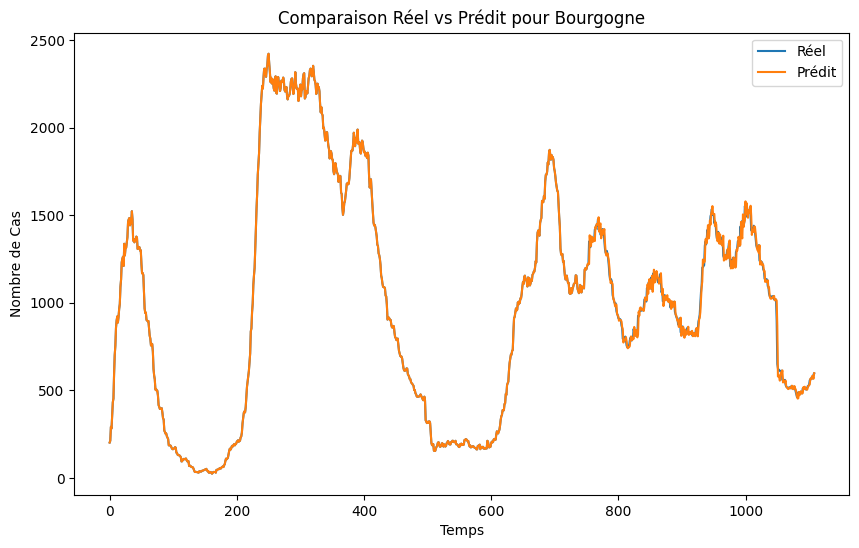

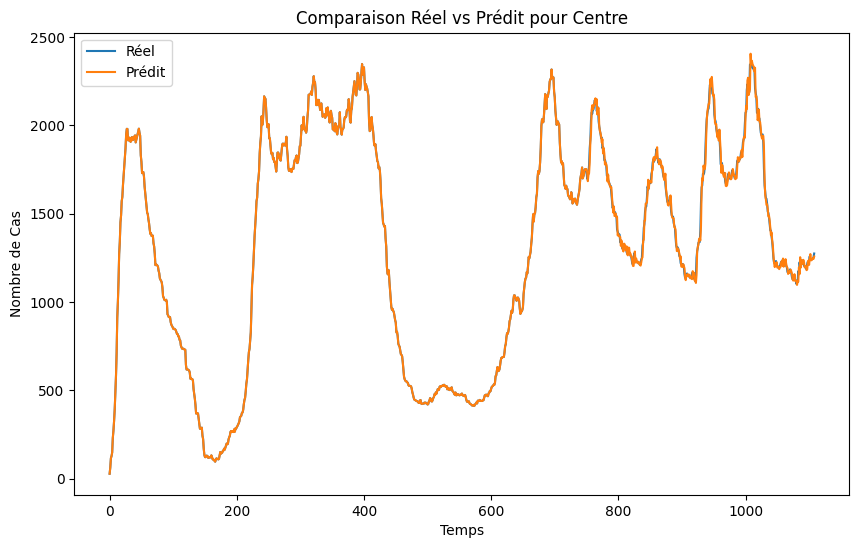

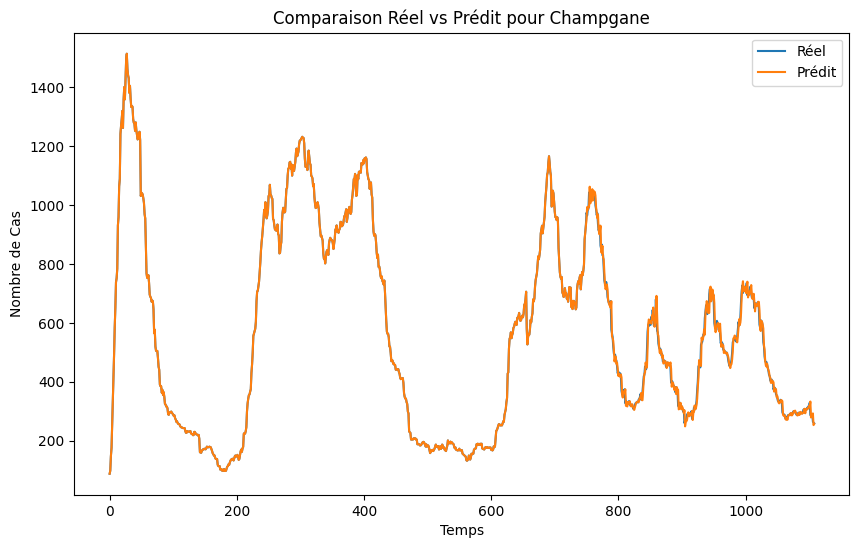

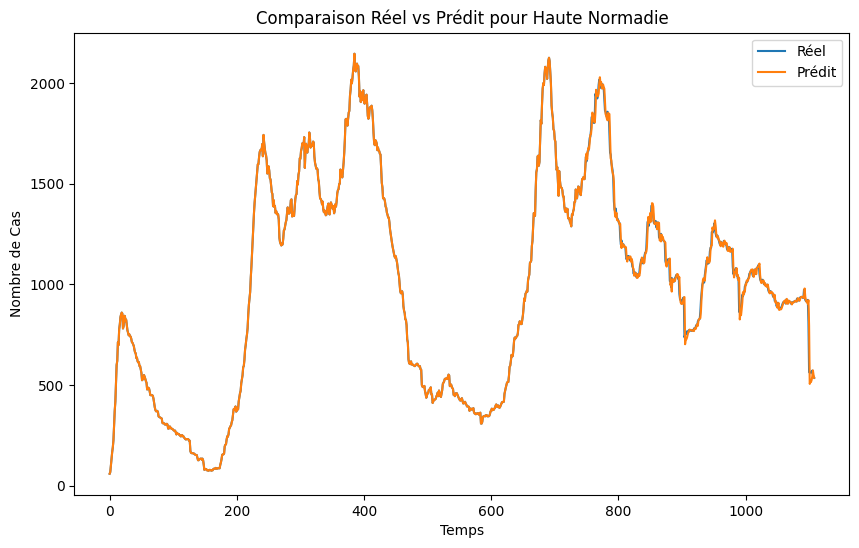

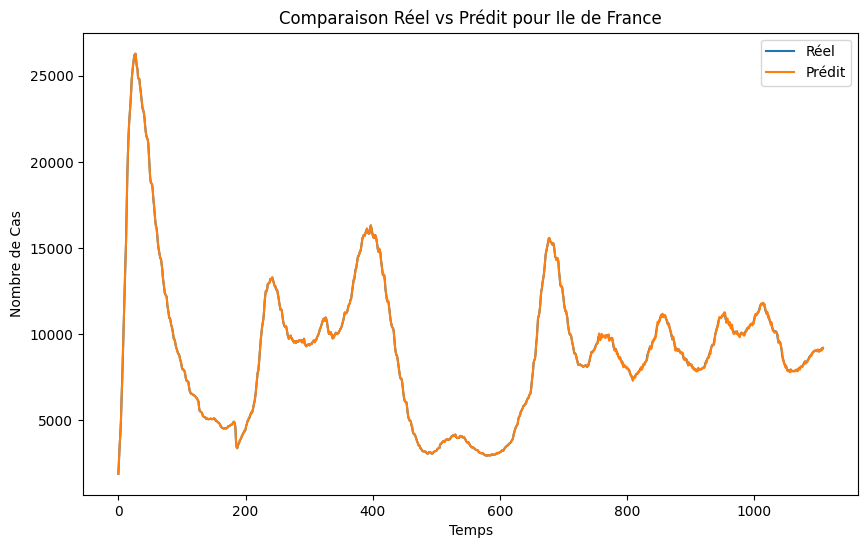

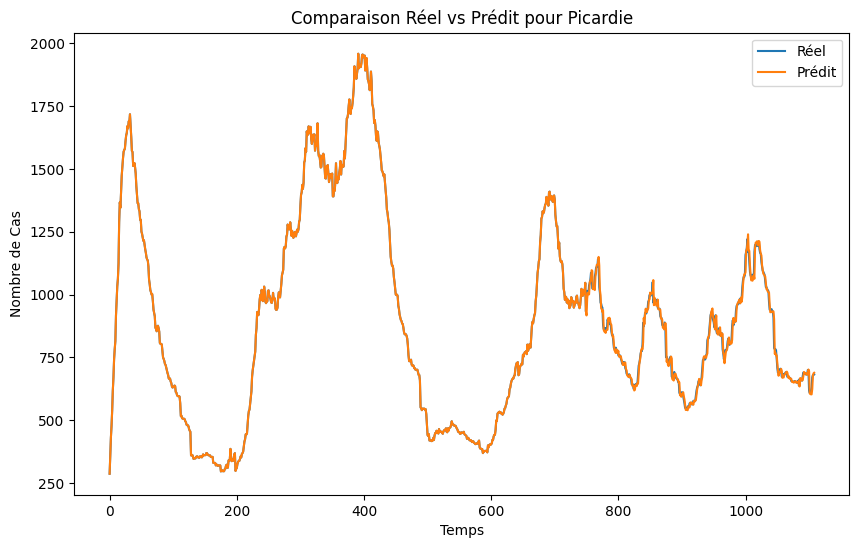

In [ ]:
def plot_real_vs_predicted(department_data, department_prediction, department_name):

    plt.figure(figsize=(10, 6))
    plt.plot(department_data, label='Réel')
    plt.plot(department_prediction, label='Prédit')
    plt.title(f'Comparaison Réel vs Prédit pour {department_name}')
    plt.xlabel('Temps')
    plt.ylabel('Nombre de Cas')
    plt.legend()
    plt.show()

for i in range(n_reg):

    plot_real_vs_predicted(listed[i], prediction[i], liste_dep[i])

#### Précision du modèle

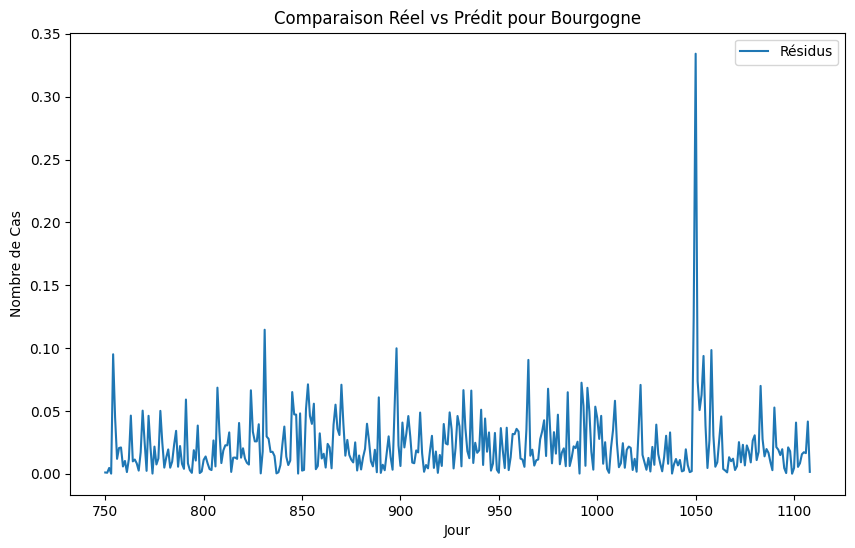

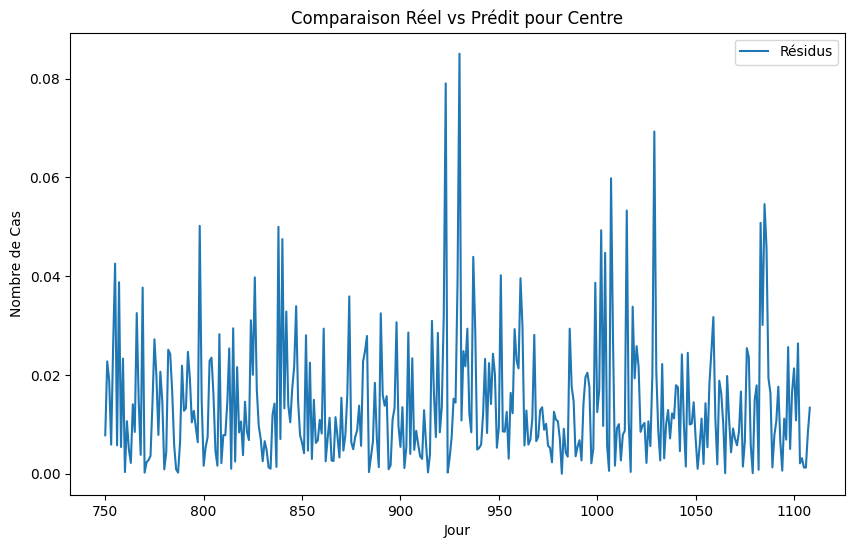

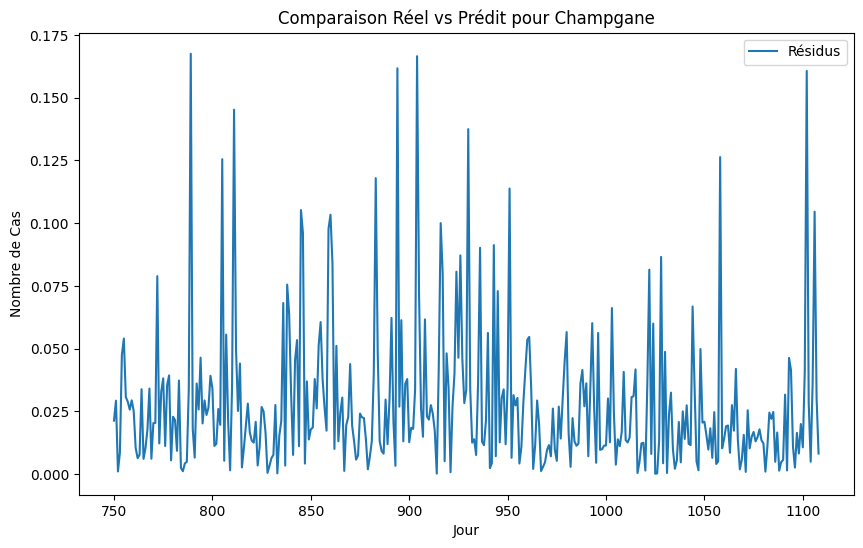

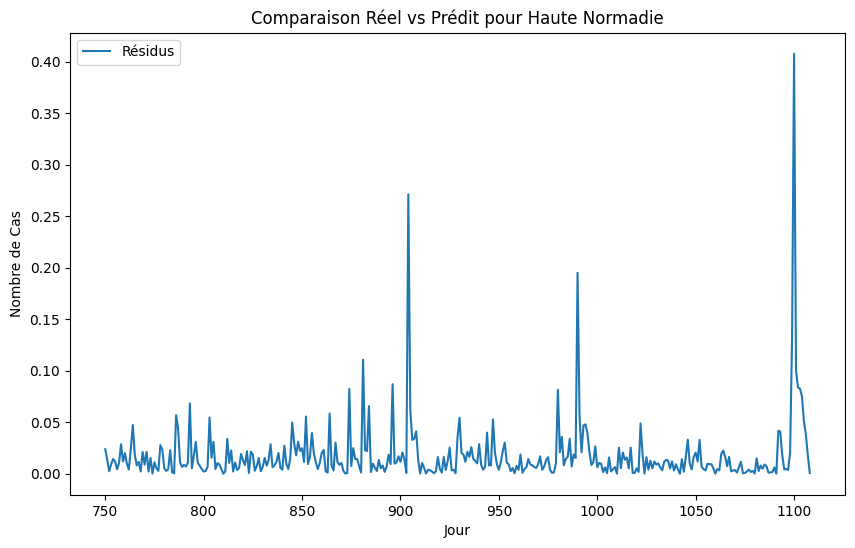

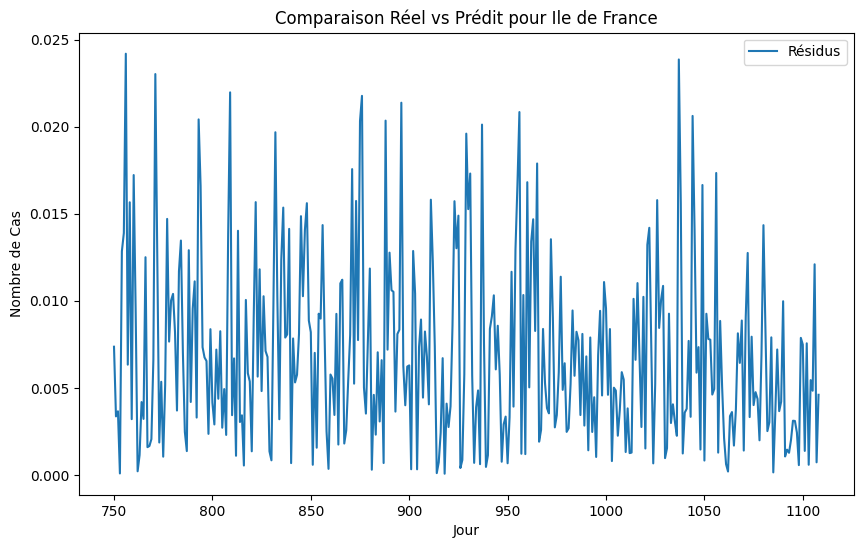

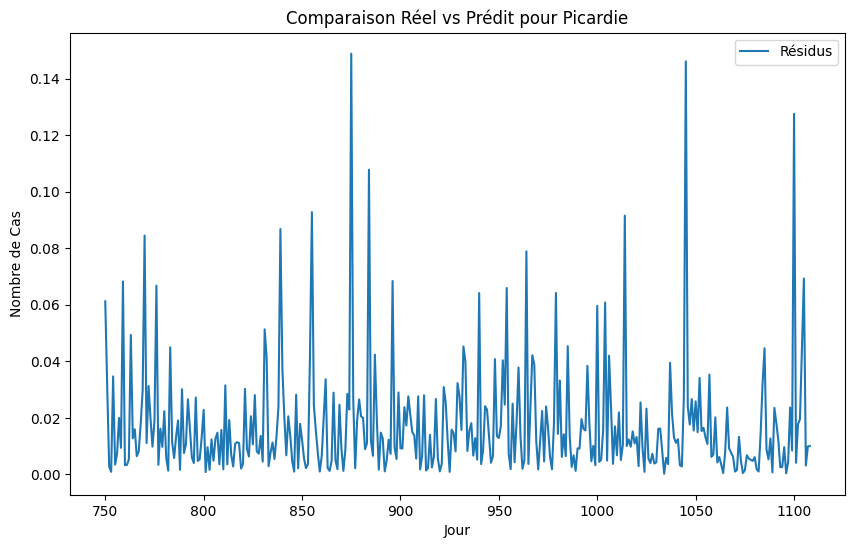

In [ ]:
def plot_residu(department_data, department_prediction, department_name):

    residu = [abs(a - b)/a for a, b in zip(department_data, department_prediction)][750:]
    plt.figure(figsize=(10, 6))
    plt.plot(range(750, 1109), residu, label='Résidus')
    plt.title(f'Comparaison Réel vs Prédit pour {department_name}')
    plt.xlabel('Jour')
    plt.ylabel('Nombre de Cas')
    plt.legend()
    plt.show()

for i in range(n_reg):

    plot_residu(listed[i], prediction[i], liste_dep[i])

In [ ]:
def prediction_fenetrage(alpha, z, taille, n, k, fen):

    case = z[-fen//2+k:fen//2+k]
    predicted_cases = [0]*(len(case)-taille)
    listes = case[:taille] + predicted_cases
    for j in range (len(predicted_cases)):
            sum = 0
            for k in range(n):

                sum += (case[taille-1+j-k])*(alpha[k])

            listes[taille+j] = sum

    return listes

prediction_fenetrage(alpha_final[0], liste[0],500,13, 5, 50 )

[]

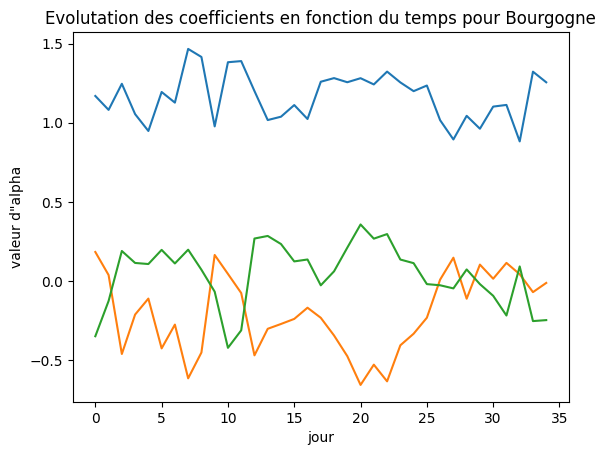

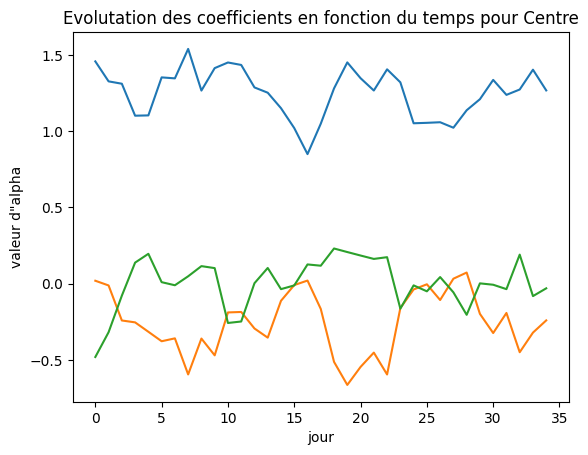

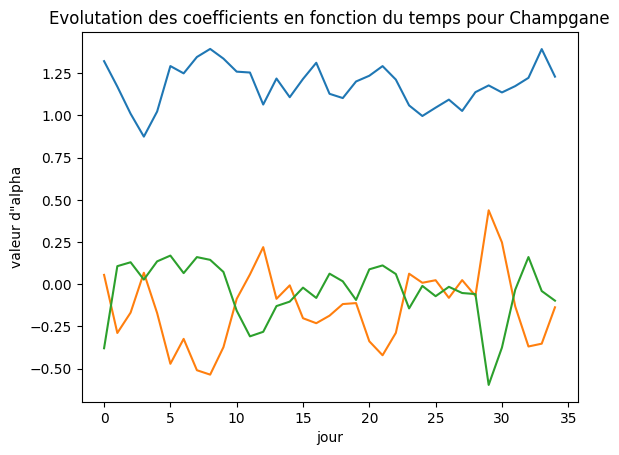

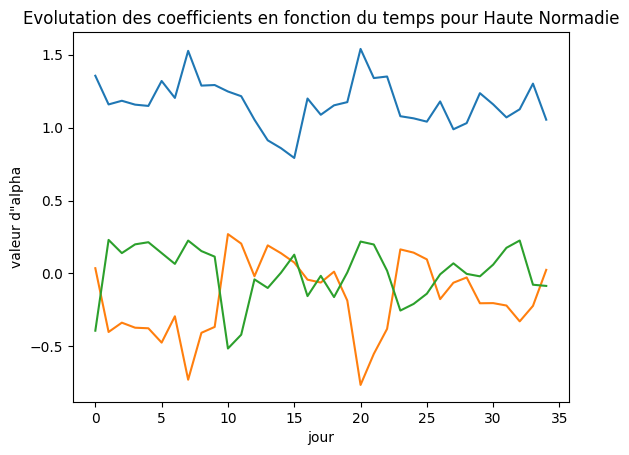

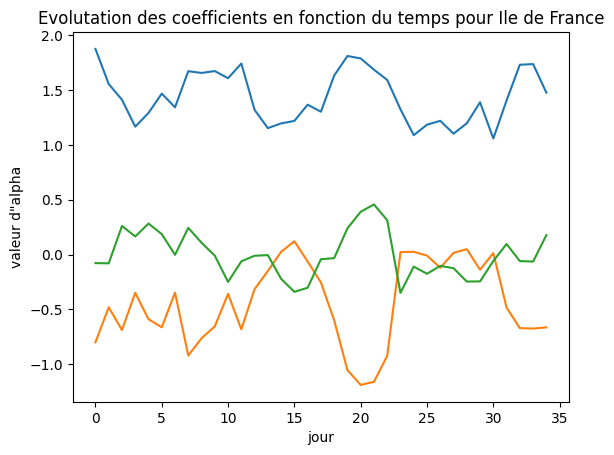

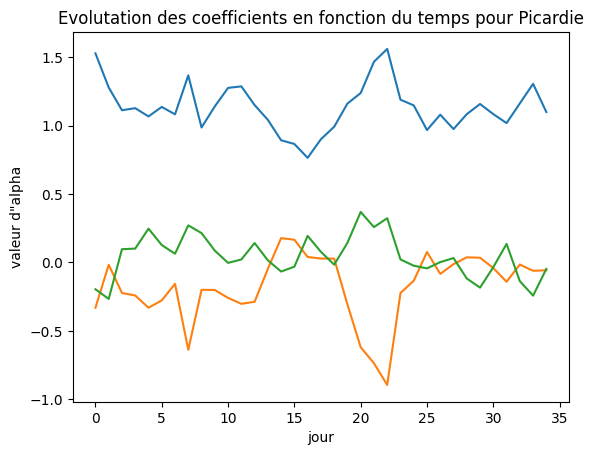

In [ ]:
def coeff_alpha(n,fen):
    """evolution des coefficients"""
    count=0
    l=[]
    for i in range(fen//2,len(liste[0])-fen//2,20):
        l.append(alpha_calculation([liste[j][-fen//2+i:fen//2+i] for j in range(len(liste))], lambda_penalty, adjacency_matrix, n))
    T=[[] for _ in range(n_reg)]
    for i in range(n):
        t=[[] for _ in range(n_reg)]
        for k in range(len(l)):
            for j in range (n_reg):
                t[j].append(l[k][j][i])
        for j in range(n_reg):
            T[j].append(t[j])
        count
    return T

coeff=coeff_alpha(3,50)
for i in range(len(coeff)):
    departement = liste_dep[i]

    for j in range (len(coeff[0])):

        plt.plot(coeff[i][j], label=f'alpha[{j}]')
    plt.title(f'Evolutation des coefficients en fonction du temps pour {departement}')
    plt.xlabel('jour')
    plt.ylabel('valeur d"alpha')
    plt.show()

In [ ]:
matrix_initial_alpha_guesses =np.array([[1]+[0.1]*(n-1) for _ in range(n_reg)])
print(listed[0])

[202, 212, 292, 282, 359, 432, 453, 593, 701, 755, 857, 899, 922, 887, 919, 965, 993, 1091, 1133, 1231, 1251, 1263, 1210, 1337, 1270, 1314, 1314, 1346, 1375, 1463, 1476, 1484, 1442, 1452, 1468, 1523, 1475, 1354, 1362, 1345, 1361, 1360, 1378, 1372, 1307, 1311, 1319, 1317, 1298, 1300, 1222, 1168, 1170, 1158, 1064, 968, 942, 944, 902, 898, 894, 896, 856, 812, 796, 756, 766, 764, 720, 623, 585, 563, 504, 508, 498, 498, 470, 416, 406, 394, 394, 396, 398, 372, 340, 334, 270, 262, 252, 254, 238, 230, 222, 186, 186, 186, 184, 176, 168, 164, 164, 168, 170, 176, 172, 144, 142, 132, 130, 130, 128, 124, 118, 94, 95, 105, 105, 109, 107, 107, 111, 103, 95, 95, 96, 68, 68, 70, 64, 62, 62, 60, 52, 42, 34, 34, 34, 34, 32, 32, 30, 38, 38, 36, 36, 40, 42, 42, 44, 46, 48, 48, 52, 46, 38, 40, 30, 30, 32, 34, 30, 24, 28, 34, 34, 34, 34, 30, 46, 46, 48, 50, 50, 56, 54, 54, 60, 62, 66, 62, 72, 78, 96, 110, 106, 111, 115, 136, 154, 167, 161, 166, 180, 184, 180, 188, 194, 186, 193, 195, 207, 211, 215, 206, 213,